# Monocle analysis of single-cell sequencing of influenza-infected cells
Study by Alistair Russell, [Cole Trapnell](http://cole-trapnell-lab.github.io/), and [Jesse Bloom](https://research.fhcrc.org/bloom/en.html).

This notebook starts with the annotated cell-gene matrix, and analyzes the expression of influenza-infected cells in various ways. 
It primarily does this using [Monocle](http://cole-trapnell-lab.github.io/monocle-release/)​.

## Setup 
Load or install necessary packages, then print information on the session that describes all packages / versions used.

In [1]:
options(warn=-1) # suppress warnings that otherwise clutter output

if (!require("pacman", quietly=TRUE)) 
  install.packages("pacman")
pacman::p_load("ggplot2", "ggthemes", "ggExtra", "gridExtra", "cowplot", "scales", "reshape2", 
  "dplyr", "magrittr", "rmarkdown", "IRdisplay", "psych", "qlcMatrix", "colorRamps", "ggpubr",
  "tidyverse", "RColorBrewer", "naturalsort")

bioc.packages <- c("monocle", "piano")
if (!(all(suppressMessages(lapply(bioc.packages, require, quietly=TRUE, character.only=TRUE))))) {
  source("http://bioconductor.org/biocLite.R")
  biocLite()
  biocLite(bioc.packages, suppressWarnings=TRUE)
}   
    
# print information on session
sessionInfo()
    
# http://www.cookbook-r.com/Graphs/Colors_(ggplot2)/#a-colorblind-friendly-palette
cbbPalette <- c("#000000", "#E69F00", "#56B4E9", "#009E73", "#F0E442", 
                "#0072B2", "#D55E00", "#CC79A7")

# plots will be saved here
plotsdir <- './results/plots/'
if (!dir.exists(plotsdir)) 
  dir.create(plotsdir)    
    
# figures for paper will be saved here
figsdir <- './paper/figures/'
if (!dir.exists(figsdir))
  dir.create(figsdir)

saveShowPlot <- function(p, width, height, isfig=FALSE) {
  # save plot with filename of variable name with dots replaced by _, then show
  # if *isfig* is TRUE, then also saves a PDF to *figsdir*
  pngfile <- file.path(plotsdir, sprintf("%s.png", 
    gsub("\\.", "_", deparse(substitute(p)))))
  figfile <- file.path(figsdir, sprintf("%s.pdf", 
    gsub("\\.", "_", deparse(substitute(p)))))
  ggsave(pngfile, plot=p, width=width, height=height, units="in")
  if (isfig)
    ggsave(figfile, plot=p, width=width, height=height, units="in")
  display_png(file=pngfile, width=width * 90)
}
    
fancy_scientific <- function(x, parse.str=TRUE, digits=NULL) {
  # scientific notation formatting, based loosely on https://stackoverflow.com/a/24241954
  # if `parse.str` is TRUE, then we parse the string into an expression
  # `digits` indicates how many digits to include
  x %>% format(scientific=TRUE, digits=digits) %>% gsub("^0e\\+00","0", .) %>%
    gsub("^1e\\+00", "1", .) %>% gsub("^(.*)e", "'\\1'e", .) %>% 
    gsub("e\\+","e", .) %>% gsub("e", "%*%10^", .) %>%
    gsub("^\'1\'\\%\\*\\%", "", .) %>% {if (parse.str) parse(text=.) else .}
}

R version 3.4.0 (2017-04-21)
Platform: x86_64-apple-darwin15.6.0 (64-bit)
Running under: macOS Sierra 10.12.6

Matrix products: default
BLAS: /Library/Frameworks/R.framework/Versions/3.4/Resources/lib/libRblas.0.dylib
LAPACK: /Library/Frameworks/R.framework/Versions/3.4/Resources/lib/libRlapack.dylib

locale:
[1] en_US.UTF-8/en_US.UTF-8/en_US.UTF-8/C/en_US.UTF-8/en_US.UTF-8

attached base packages:
 [1] splines   stats4    parallel  stats     graphics  grDevices utils    
 [8] datasets  methods   base     

other attached packages:
 [1] piano_1.16.1        monocle_2.5.3       DDRTree_0.1.5      
 [4] irlba_2.2.1         VGAM_1.0-3          Biobase_2.36.2     
 [7] BiocGenerics_0.22.0 naturalsort_0.1.3   RColorBrewer_1.1-2 
[10] purrr_0.2.2.2       readr_1.1.1         tidyr_0.6.3        
[13] tibble_1.3.3        tidyverse_1.1.1     ggpubr_0.1.4       
[16] colorRamps_2.3      qlcMatrix_0.9.5     slam_0.1-40        
[19] Matrix_1.2-10       psych_1.7.5         IRdisplay_0.4.4    
[22] rm

## Create cell-gene dataset, examine basic statistics, filter cells 
Read in cell-gene data for all samples.
This is the merged cell-gene data set constructed with `cellranger` using the iPython notebook.
The cells are annotated by the number of wildtype and synonymous-barcoded influenza UMIs called for each cell.

After reading the cells, we just get the samples that interest us (currently this is all samples).

In [2]:
matrixfile <- "results/cellgenecounts/merged_humanplusflu_matrix.mtx"
genesfile <- "results/cellgenecounts/merged_humanplusflu_genes.tsv"
cellsfile <- "results/cellgenecounts/merged_humanplusflu_cells.tsv"

all.cells <- newCellDataSet(readMM(matrixfile),
  phenoData=new("AnnotatedDataFrame", data=read.delim(cellsfile)),
  featureData=new("AnnotatedDataFrame", data=read.delim(genesfile)),
  expressionFamily=negbinomial.size())

samples <- c("Uninfected", "6hr", "8hr", "8hr-2", "10hr")
all.cells <- all.cells[, row.names(subset(pData(all.cells), Sample %in% samples))]

Plot the number of cells in each sample.

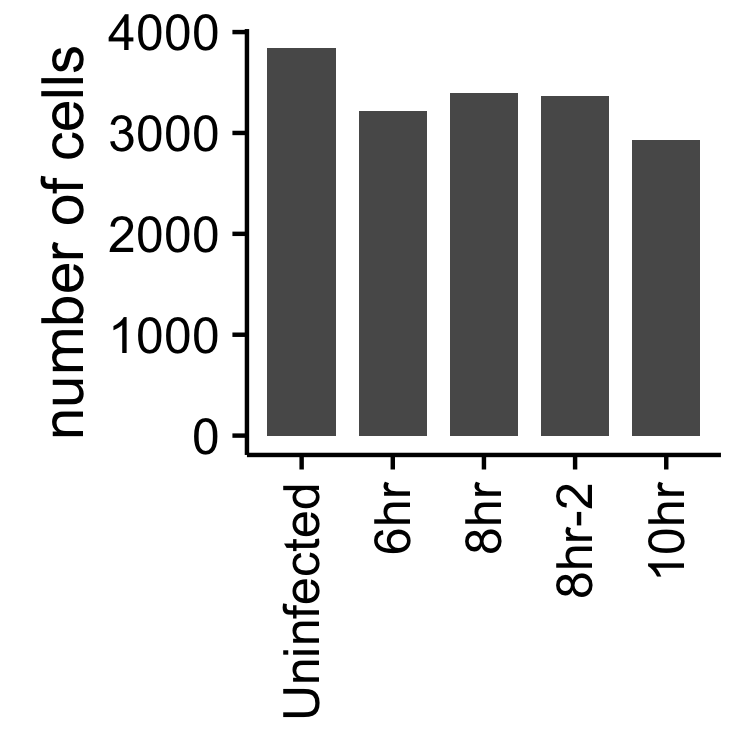

In [3]:
p.ncells.per.sample <- ggplot(
    pData(all.cells) %>% transform(Sample=factor(Sample, samples)) %>% arrange(Sample), 
    aes(Sample)) + 
  scale_y_continuous(name="number of cells") + 
  geom_bar(width=0.75) + 
  scale_x_discrete(name=NULL) +
  theme(axis.text.x=element_text(angle=90, hjust=1, vjust=0.5))

saveShowPlot(p.ncells.per.sample, width=2.5, height=2.5)

Compute the number of total mRNAs, cellular mRNAs, influenza mRNAs, and fraction of influenza mRNAs per cell.
Then plot a cumulative distribution plot of the fraction of mRNAs that are from influenza for each sample.

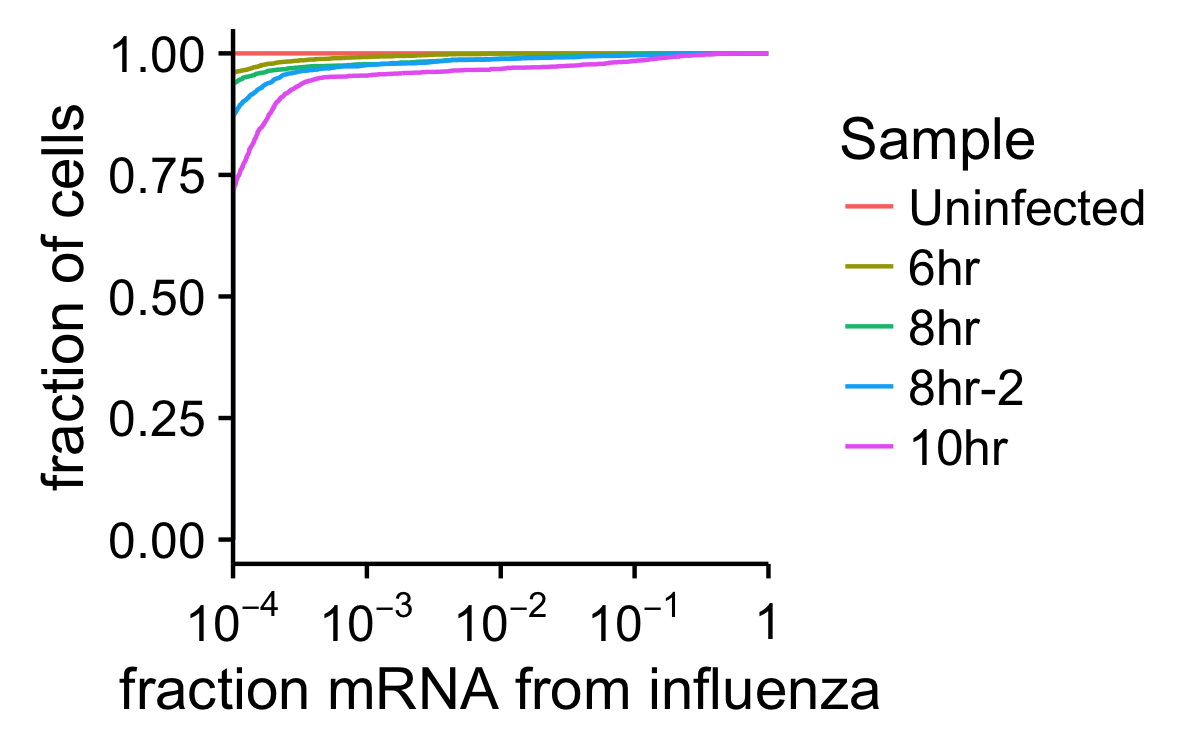

In [4]:
pData(all.cells)$total.mRNAs <- Matrix::colSums(exprs(all.cells))

flugenes <- c("fluPB2", "fluPB1", "fluPA", "fluHA", "fluNP", "fluNA", "fluM", "fluNS")
pData(all.cells)$flu.mRNAs <- Matrix::colSums(exprs(all.cells[
  row.names(subset(fData(all.cells), gene_short_name %in% flugenes)),]))

pData(all.cells)$cellular.mRNAs <- Matrix::colSums(exprs(all.cells[
  row.names(subset(fData(all.cells), !(gene_short_name %in% flugenes))),]))

pData(all.cells)$frac.flu.mRNAs <- pData(all.cells)$flu.mRNAs / 
  pData(all.cells)$total.mRNAs

# some trickery around x minimum to avoid taking log of 0 
minx <- 1e-4 # minimum value on y-axis
pData(all.cells)$log.frac.flu <- ifelse(pData(all.cells)$frac.flu.mRNAs < minx, 
  log10(minx), log10(pData(all.cells)$frac.flu.mRNAs))

p.mRNA.per.cell.cumul <- ggplot(
    transform(pData(all.cells), Sample=factor(Sample, samples)), # order by sample 
    aes(log.frac.flu, color=Sample)) +
  stat_ecdf() +
  scale_x_continuous(labels=function(x){fancy_scientific(10**x)},
    limits=c(log10(minx), 0), expand=c(0, 0), name="fraction mRNA from influenza") +
  scale_y_continuous(limits=c(0, 1), name="fraction of cells") + 
  theme(axis.text.x=element_text(vjust=0.2))

saveShowPlot(p.mRNA.per.cell.cumul, width=4, height=2.5)

The [Monocle vignette](http://cole-trapnell-lab.github.io/monocle-release/) suggests filtering cells with far more / less mRNAs than most cells.

In our case, it isn't clear whether we should filter on the amount of *total* mRNA or on the *cellular* mRNA, since it isn't clear whether viral infection increases the total mRNA or whether the synthesis of viral mRNA comes at the expense of cellular mRNA.

Below, we decide to filter on the amount of *cellular* mRNA since it appears that cells with lots of viral mRNA don't necessarily have less cellular mRNA, suggesting that viral infection might increase the total amount of mRNA.

Specifically, we filter to cells that are within 2.5-fold of the median number of cellular mRNAs per cells. 
This filter is substantially more lenient than that in the [Monocle vignette](http://cole-trapnell-lab.github.io/monocle-release/), but seems safer as we don't want to lose virally infected cells -- and as the plot below makes clear, some of the virally infected cells have quite a bit of cellular mRNA.

The filtering cutoff is sample-specific, since different samples were sequenced to different depths.

First, determine the filtering cutoffs:

In [5]:
# set upper and lower bounds as range around mean for each sample
pData(all.cells)$sample.mean.mRNAs <- pData(all.cells) %>% group_by(Sample) %>% 
  mutate(mean=mean(cellular.mRNAs)) %>% ungroup %>% select(mean) %>% unlist
pData(all.cells)$lower.bound <- pData(all.cells)$sample.mean.mRNAs / 2.5
pData(all.cells)$upper.bound <- pData(all.cells)$sample.mean.mRNAs * 2.5

# print table of upper and lower bounds for each sample
pData(all.cells) %>% group_by(Sample) %>% summarize(
  mean.cellular.mRNA=sample.mean.mRNAs %>% first %>% as.integer, 
  lower.bound.cellular.mRNA=lower.bound %>% first %>% as.integer, 
  upper.bound.cellular.mRNA=upper.bound %>% first %>% as.integer) 

Sample,mean.cellular.mRNA,lower.bound.cellular.mRNA,upper.bound.cellular.mRNA
10hr,13542,5417,33856
6hr,13431,5372,33578
8hr,13681,5472,34204
8hr-2,11978,4791,29945
Uninfected,13258,5303,33147


Next, plot the filtering cutoffs as red lines.
The blue lines show the distribution of cellular mRNAs per cell.

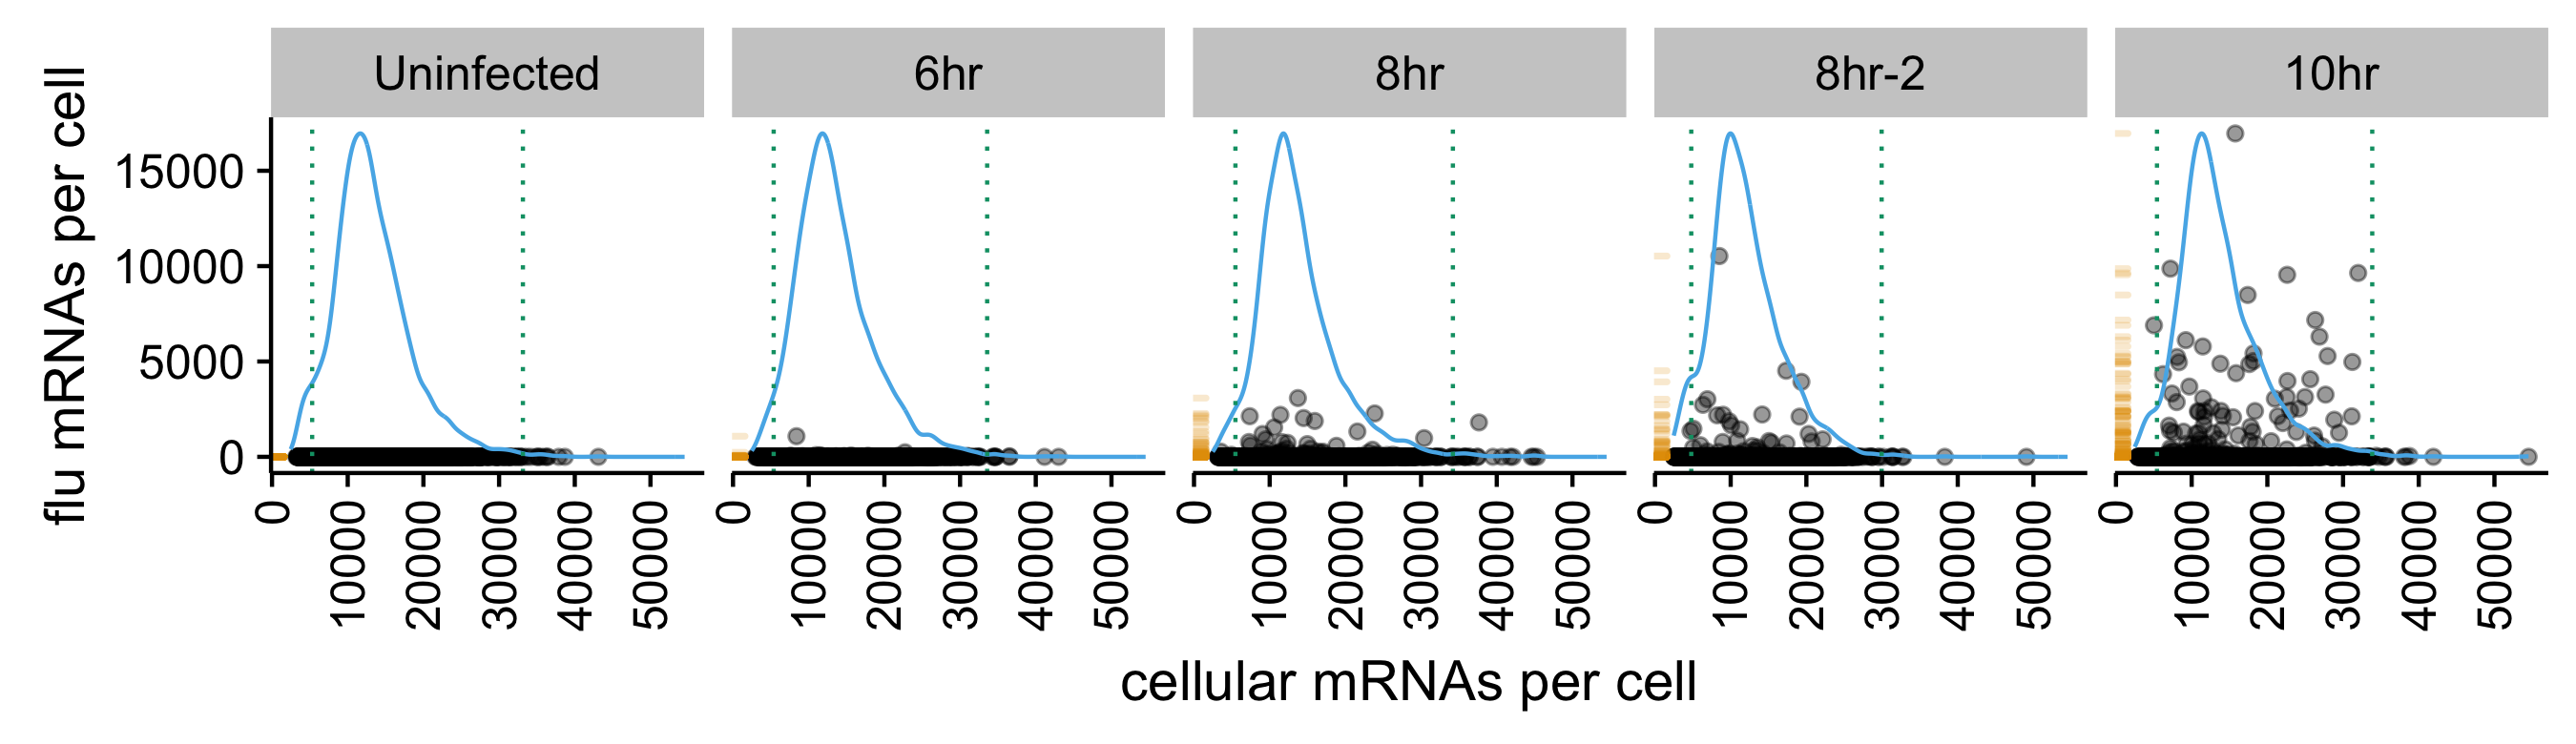

In [6]:
scatterplot <- ggplot(
    transform(pData(all.cells), Sample=factor(Sample, levels=samples)), # order by sample
    aes(cellular.mRNAs, flu.mRNAs), color=cbbPalette[[1]]) +
  geom_point(alpha=0.4) + 
  geom_rug(sides='l', alpha=0.2, color=cbbPalette[[2]], size=0.8)

# use eval substitute to get value of maxy as here: https://stackoverflow.com/a/10659563
densityplot <- eval(substitute(
  {stat_density(aes(x=cellular.mRNAs, y=maxy*(..scaled..)), geom="line", color=cbbPalette[[3]])},
  list(maxy=layer_scales(scatterplot)$y$range$range[2])))

p.flu.vs.cell <- scatterplot + densityplot + 
  theme(axis.text.x=element_text(angle=90, vjust=0.5, hjust=1)) +  
  geom_vline(aes(xintercept=lower.bound), color=cbbPalette[[4]], linetype='dotted') +
  geom_vline(aes(xintercept=upper.bound), color=cbbPalette[[4]], linetype='dotted') +
  facet_wrap(~Sample, nrow=1) + xlab("cellular mRNAs per cell") + 
  ylab("flu mRNAs per cell") 

saveShowPlot(p.flu.vs.cell, width=9, height=2.6)

Now apply the filtering cutoff to the cells:

In [7]:
cells <- all.cells[, row.names(subset(pData(all.cells), 
    total.mRNAs > lower.bound & total.mRNAs < upper.bound))]

Here is a plot verifying that heavily influenza-infected cells do indeed have more *total* mRNA than non-infected cells, but **not** greatly more *cellular mRNA*.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


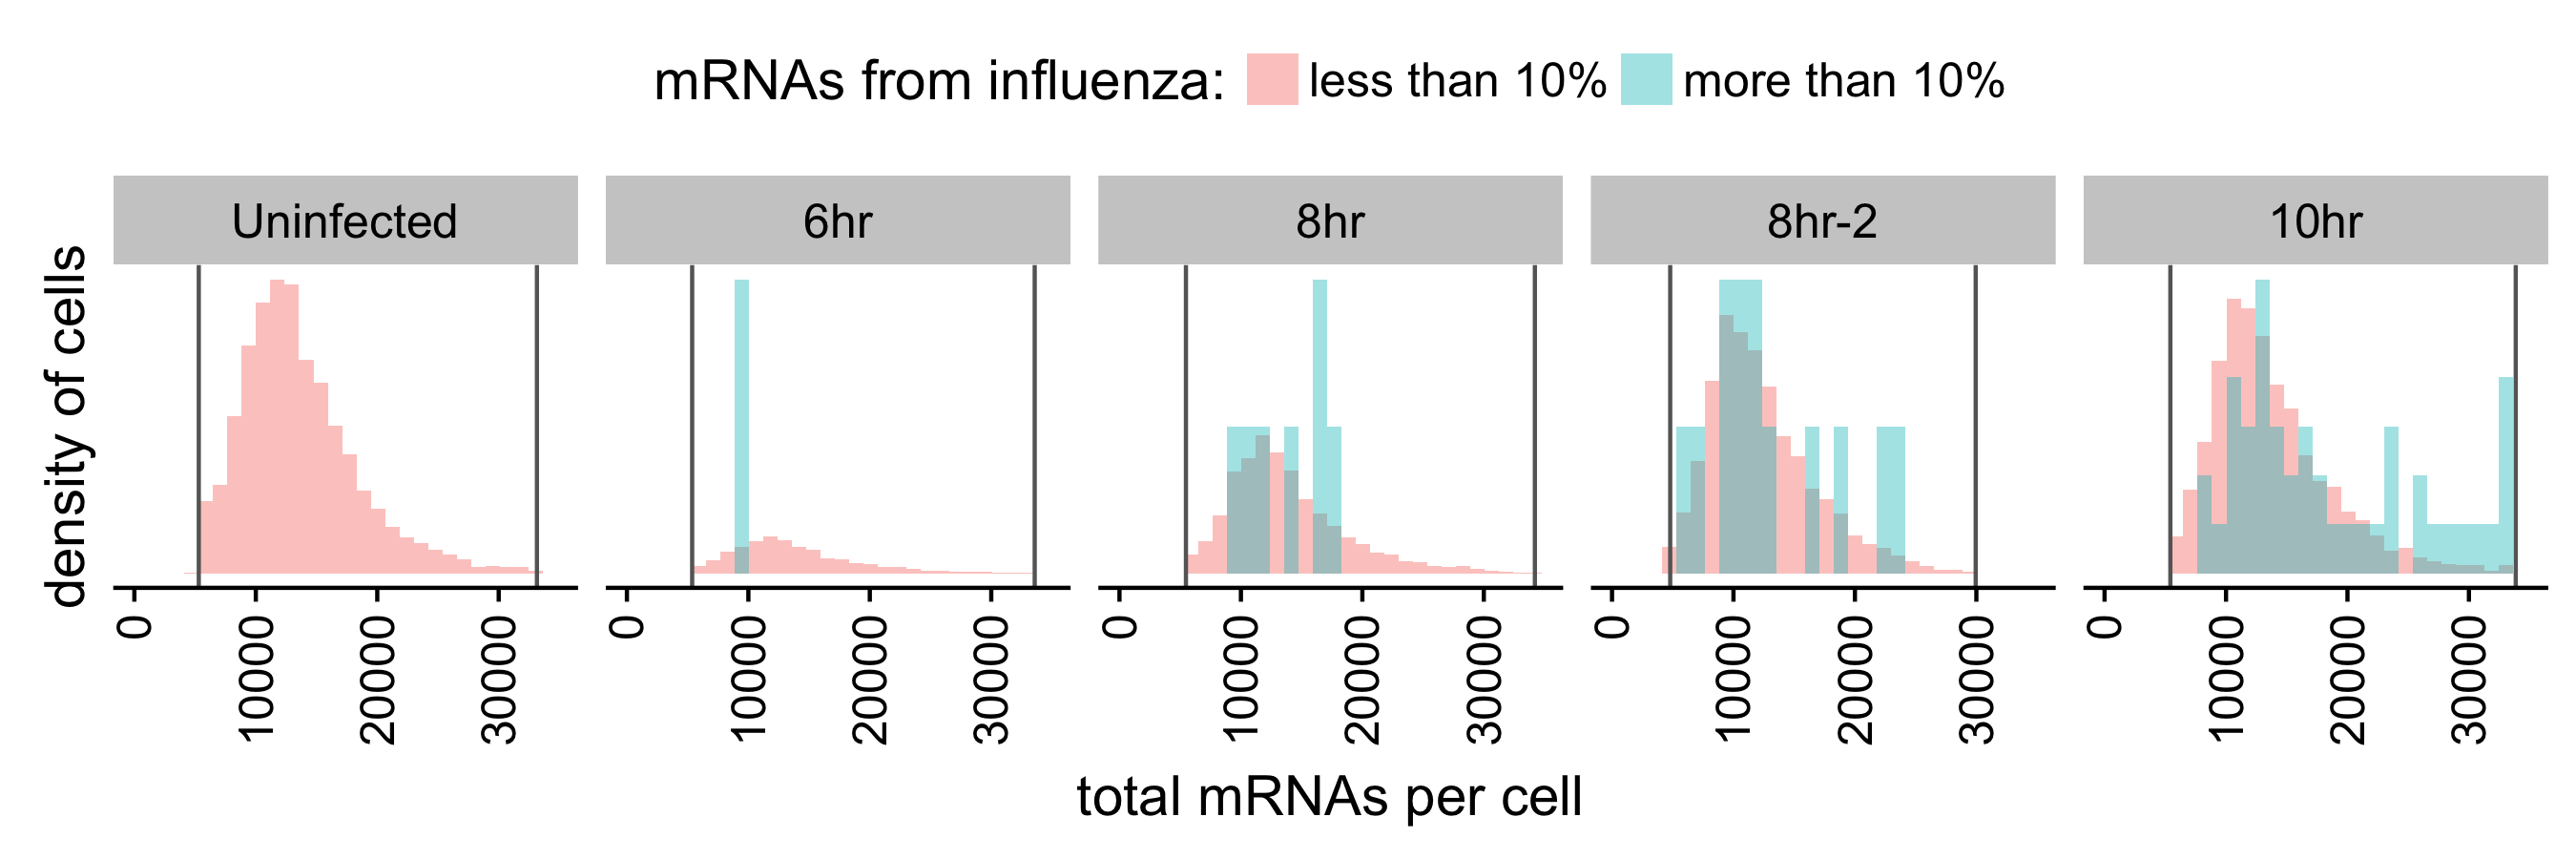

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


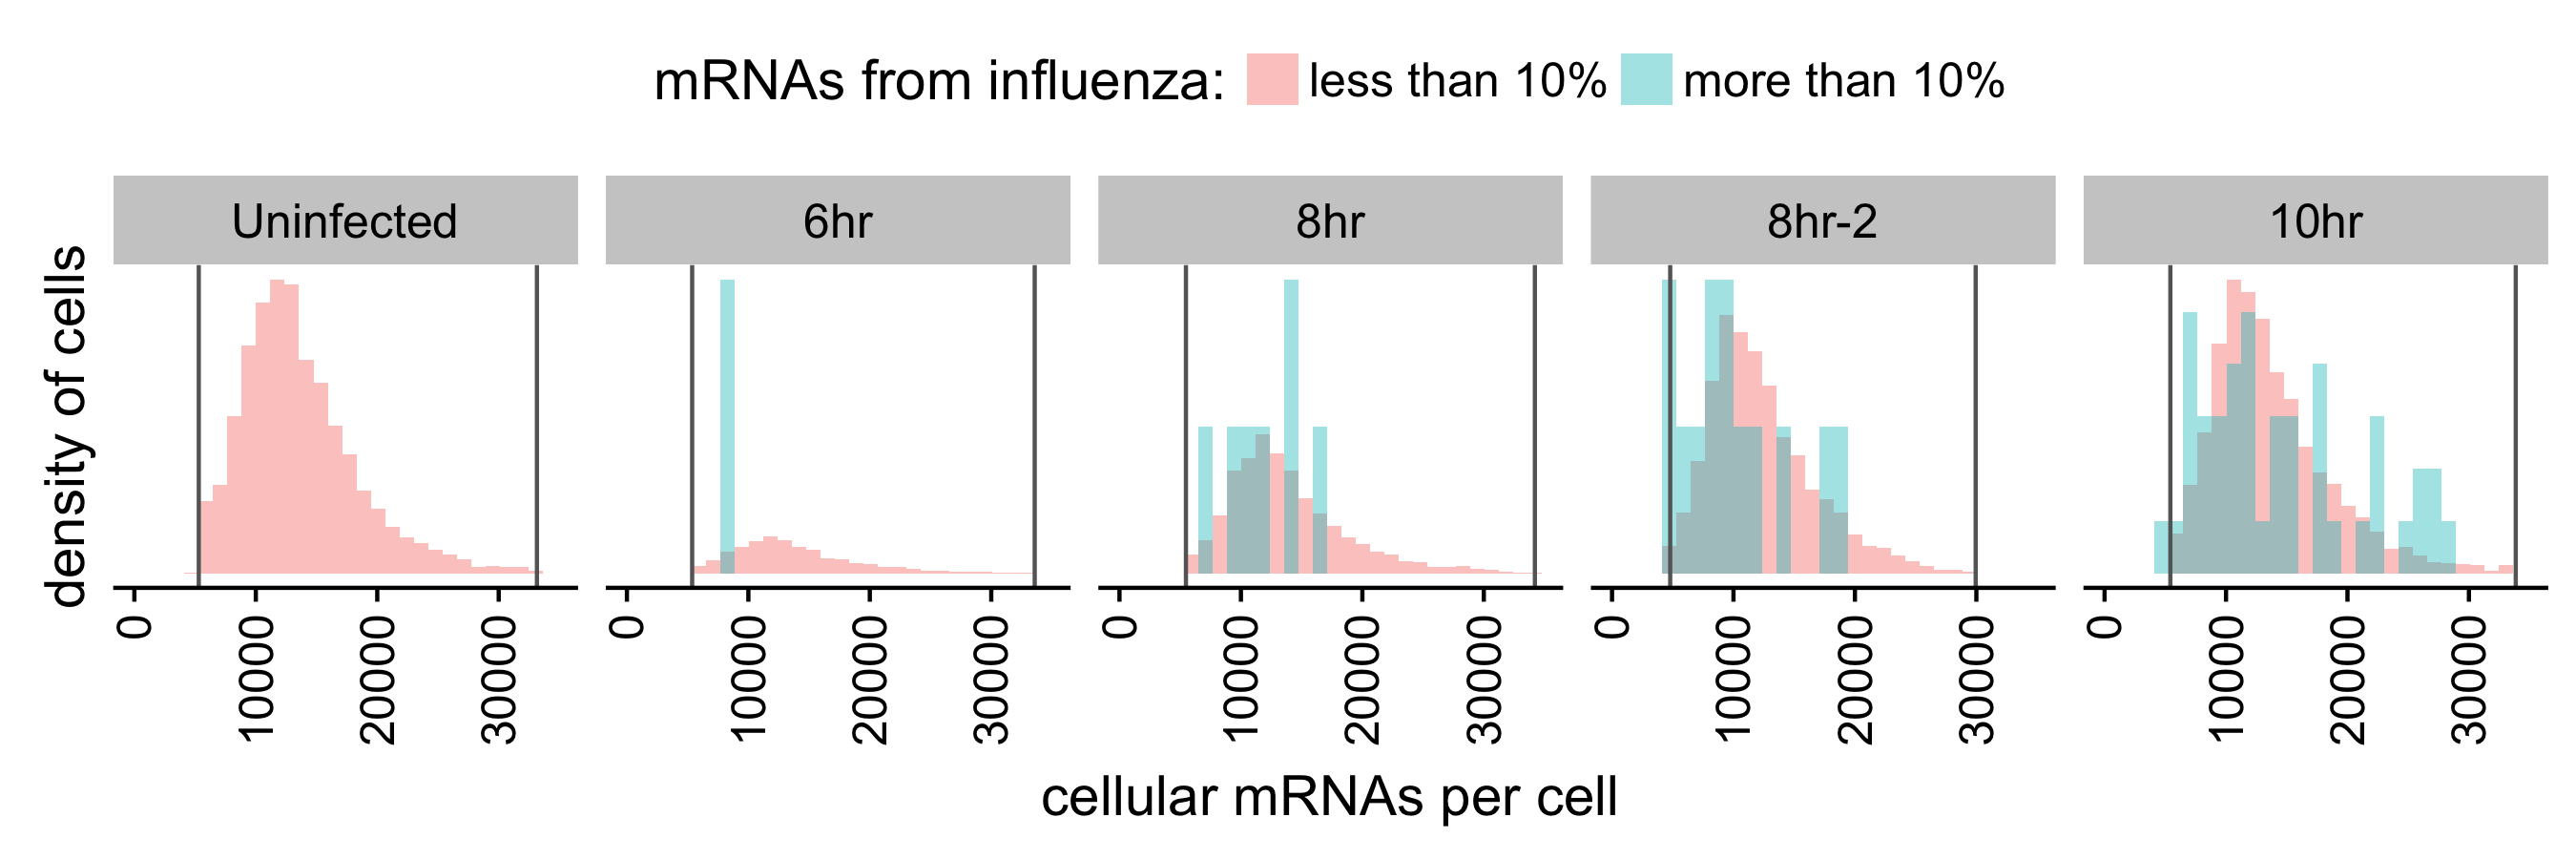

In [8]:
# classify cells with more and less than certain number of flu mRNAs
frac.flu.cutoff <- 0.1
pData(cells)$frac.flu.above.cutoff <- ifelse(
  pData(cells)$frac.flu.mRNAs > frac.flu.cutoff,
  sprintf("more than %.0f%%", 100 * frac.flu.cutoff), 
  sprintf("less than %.0f%%", 100 * frac.flu.cutoff))

# plot density of total mRNAs per cell 
p.mRNA.density <- ggplot(
    transform(pData(cells), Sample=factor(Sample, samples)), 
    aes(total.mRNAs, fill=frac.flu.above.cutoff)) +
  geom_histogram(alpha=0.4, aes(y=..density..), position='identity') +
  theme(axis.text.x=element_text(angle=90, vjust=0.5, hjust=1), legend.position="top") +
  scale_y_continuous(label=NULL, name="density of cells", breaks=NULL, limits=c(0, NA)) +
  scale_x_continuous(limits=c(0, NA)) +
  xlab("total mRNAs per cell") +
  labs(fill="mRNAs from influenza:") +
  geom_vline(aes(xintercept=lower.bound), color="gray40") +
  geom_vline(aes(xintercept=upper.bound), color="gray40") +
  facet_wrap(~Sample, nrow=1, scales="free_y")
saveShowPlot(p.mRNA.density, width=9, height=3)

# do the same for cellular mRNAs per cell
p.cell.mRNA.density <- ggplot(
    transform(pData(cells), Sample=factor(Sample, samples)), 
    aes(cellular.mRNAs, fill=frac.flu.above.cutoff)) +
  geom_histogram(alpha=0.4, aes(y=..density..), position='identity') +
  theme(axis.text.x=element_text(angle=90, vjust=0.5, hjust=1), legend.position="top") +
  scale_y_continuous(label=NULL, name="density of cells", breaks=NULL, limits=c(0, NA)) +
  scale_x_continuous(limits=c(0, NA)) +
  xlab("cellular mRNAs per cell") +
  labs(fill="mRNAs from influenza:") +
  geom_vline(aes(xintercept=lower.bound), color="gray40") +
  geom_vline(aes(xintercept=upper.bound), color="gray40") +
  facet_wrap(~Sample, nrow=1, scales="free_y")
saveShowPlot(p.cell.mRNA.density, width=9, height=3)

Make a summary plot merging key panels. 
This is designed to be a publication-quality figure.

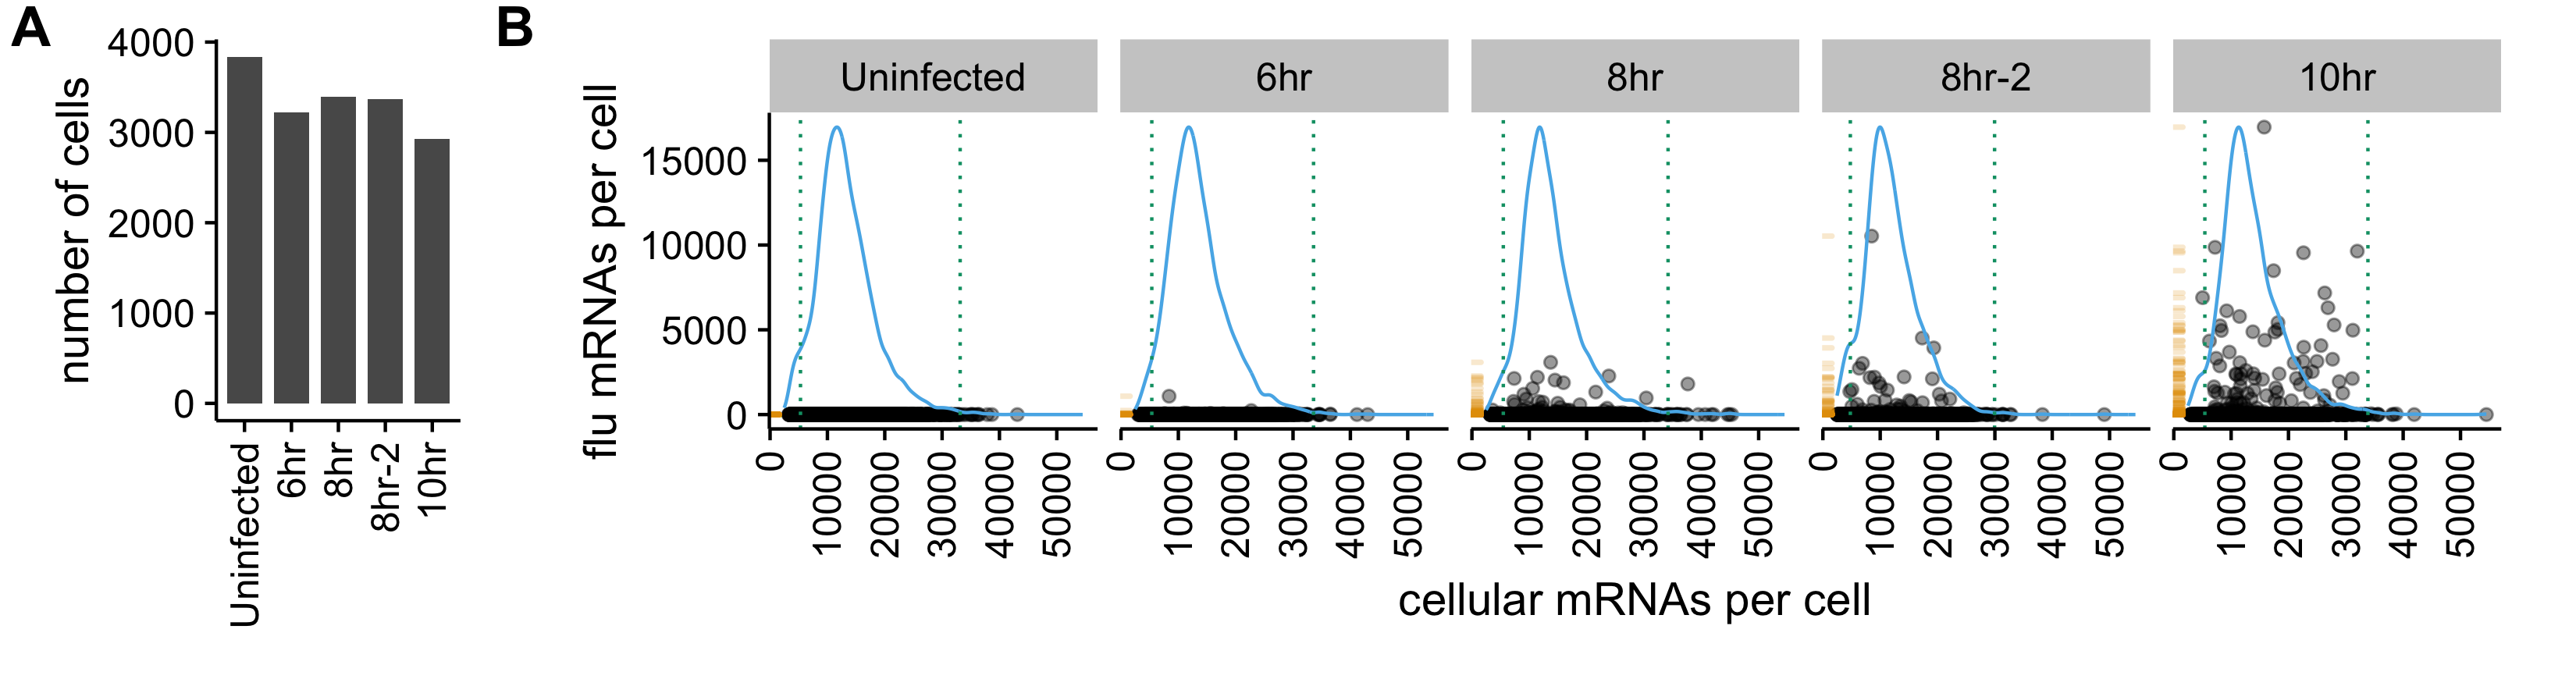

In [9]:
p.cell.mRNA.summary <- plot_grid(
  p.ncells.per.sample, p.flu.vs.cell, ncol=2, align='h', 
  labels=c("A", "B"), label_size=17, vjust=0.3, hjust=0, scale=0.95, 
  rel_widths=c(1, 4.3))
  
saveShowPlot(p.cell.mRNA.summary, width=11, height=2.9, isfig=TRUE)

## Look at levels of influenza genes, use synonymous barcodes to detect true infection / co-infection versus mRNA leakage, filter cells
Roughly half of the infecting influenza viruses had a synonymous barcode at the 3' end of each mRNA.
If cells infected by a single virus (which we expect to be the most common case for infected cells since infection itself is rare), then they should generally have either all wildtype or all synonymously barcoded viruses.
Looking for deviations from this expectation can identify both true infection / co-infection and cells that just got some influenza mRNA by leakage, since such leakage is expected to introduce a mix of both wildtype and synonymously barcoded.
Establishing when cells start to have influenza mRNA due to true infection versus simple leakage is important for figuring identifying truly infected cells.

We limit the analysis below to cells that meet the following criteria:

  1. They have at least two influenza reads in the cell-gene matrix.

  2. They have at least two called barcodes (synonymous or wildtype) called on these influenza reads.

These criteria limit the analysis just to cells where there is actual information about the synonymous barcodes.
First, we filter down to these cells and plot some information about them.
Note that these plots show the number of influenza mRNAs on a log scale, and then color the bars by the fraction of reads from each barcode.
So the heights of each color in the bars are proportional to the fraction of the reads with that barcode, they are **not** the log of the number of reads with each barcode.

`mutate_each()` is deprecated.
Use `mutate_all()`, `mutate_at()` or `mutate_if()` instead.
To map `funs` over all variables, use `mutate_all()`


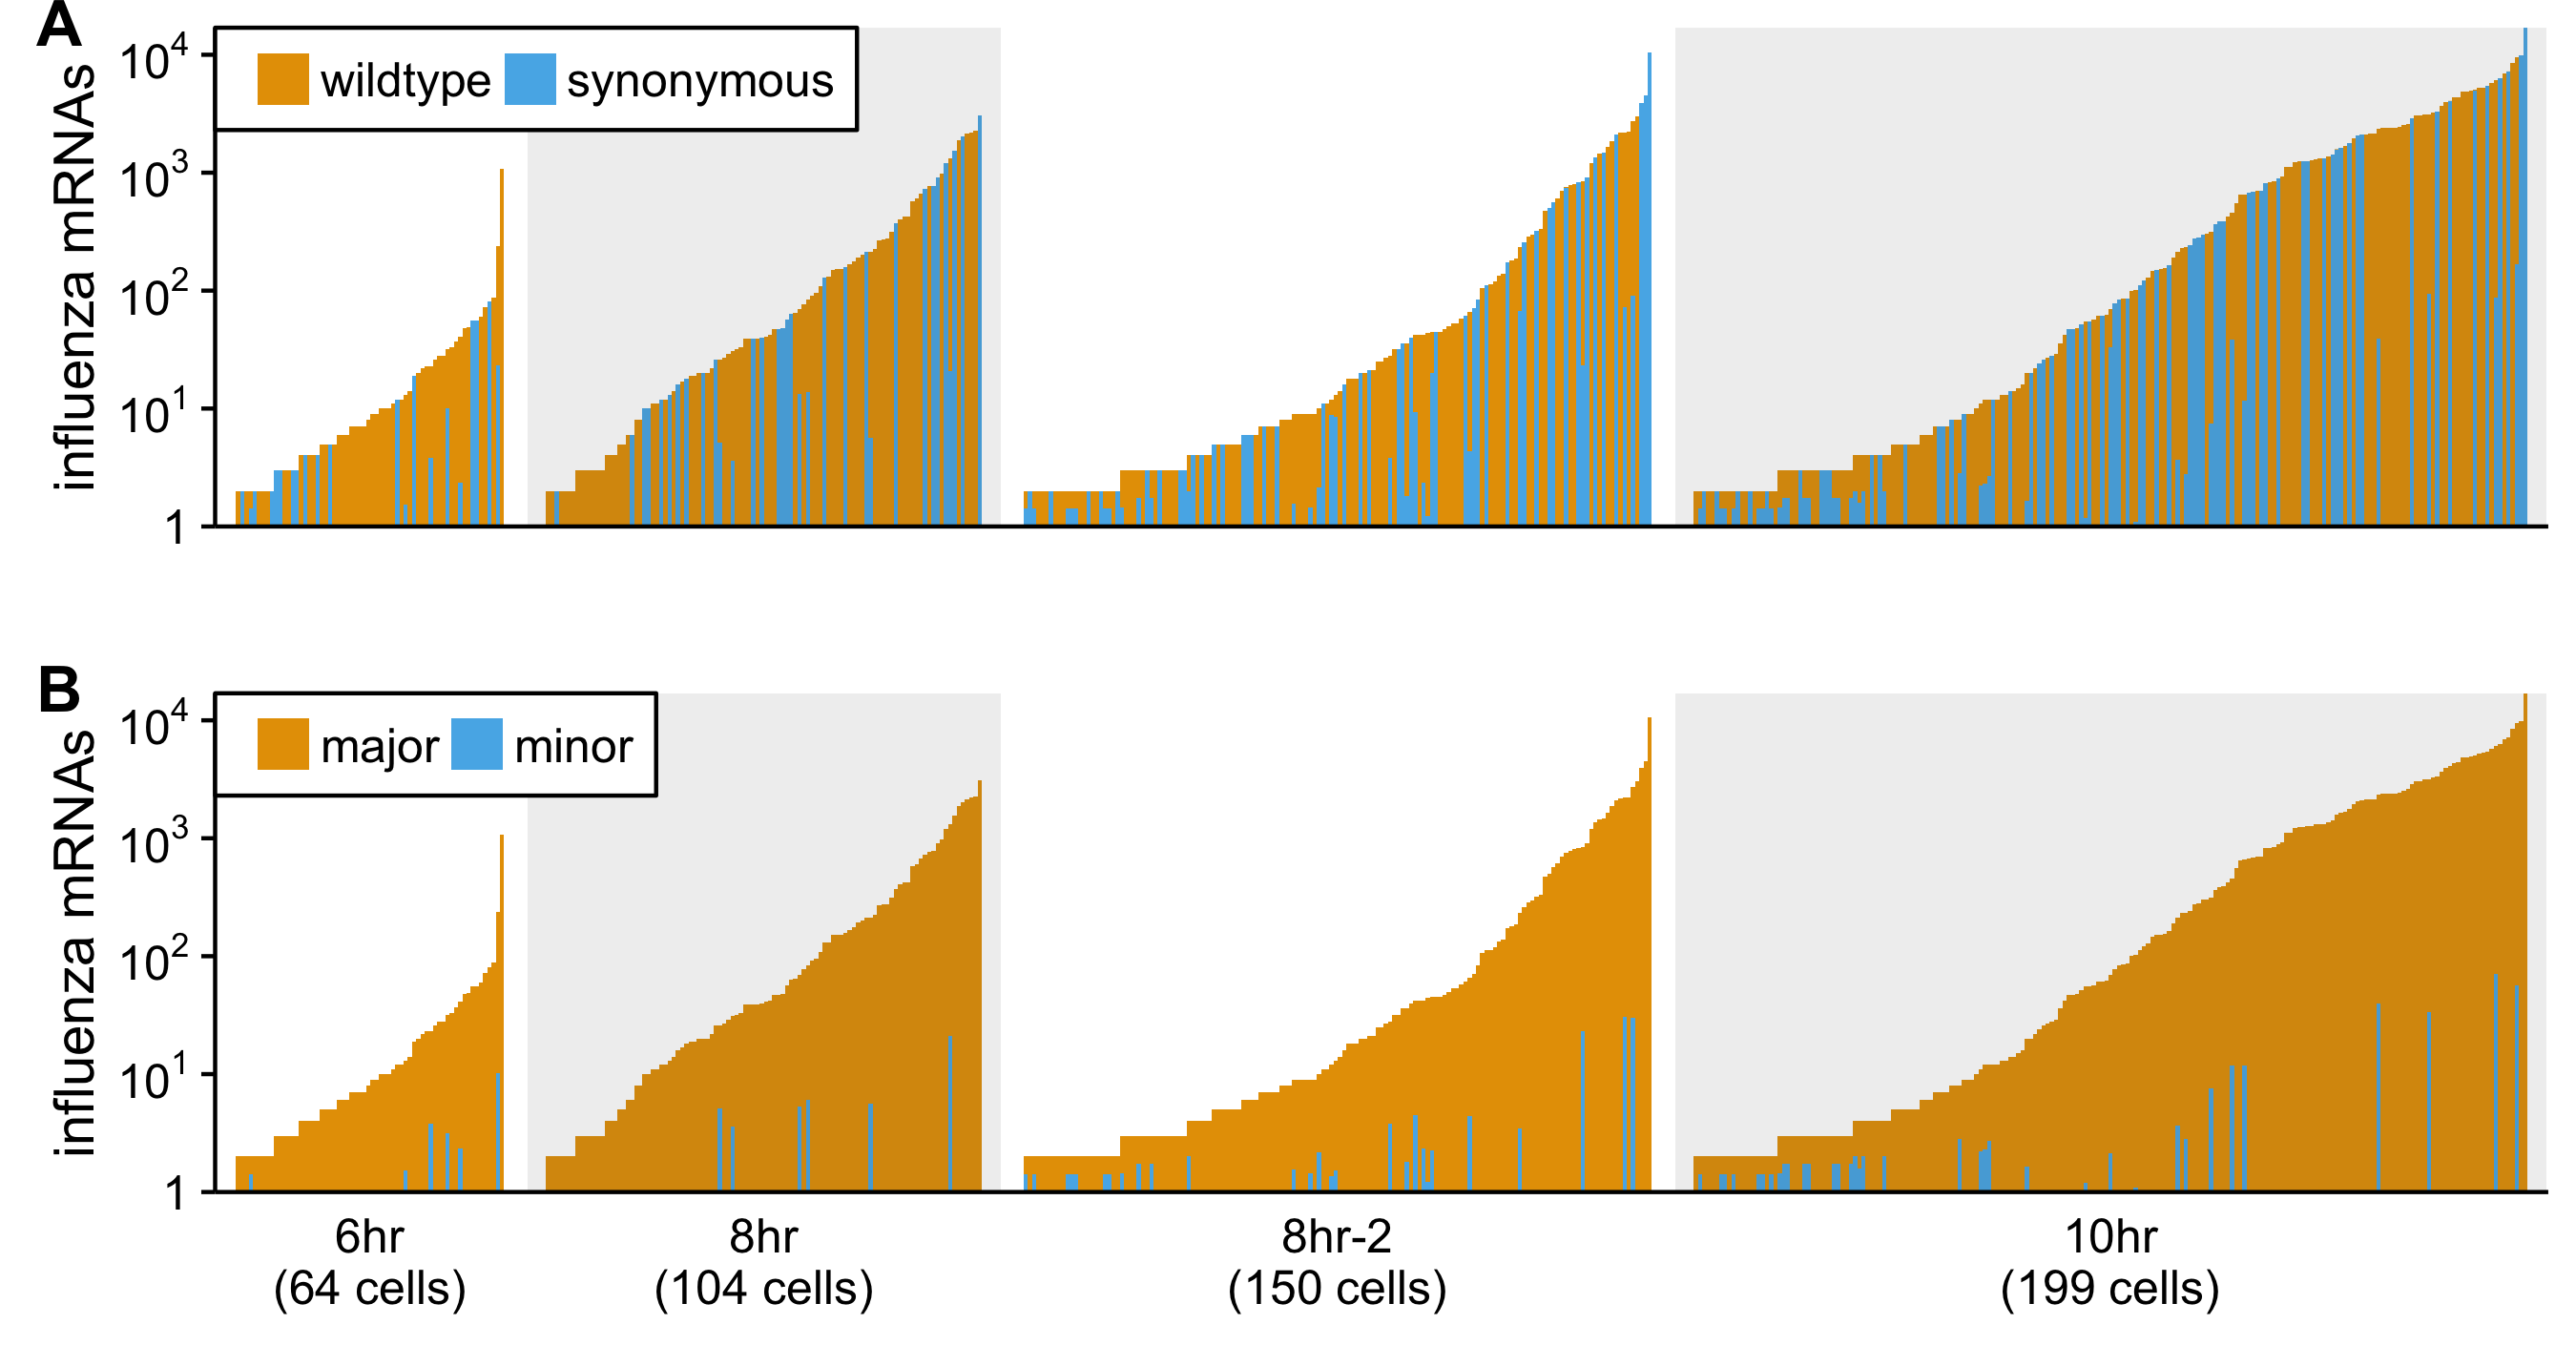

In [10]:
options(warn=-1) # suppress warnings that otherwise clutter output

# filter on sufficiently barcoded cells and samples with such cells
bc.cells <- filter(pData(cells), flu.mRNAs >= 2, flu.wt + flu.syn >= 2)
samples.to.plot <- bc.cells[["Sample"]] %>% unlist %>% unique

# make variables with product of log flu mRNAs times fraction with each barcode
bc.cells <- bc.cells %>% mutate(frac.wt=(flu.wt / (flu.wt + flu.syn))) %>%
  mutate(wildtype=log10(flu.mRNAs) * frac.wt, 
    synonymous=log10(flu.mRNAs) * (1 - frac.wt)) %>%
  mutate(major=pmax(wildtype, synonymous), minor=pmin(wildtype, synonymous))

# make some dummy rows with 0 or many influenza to "pad" between samples on the plot
npad <- 5 # pad this many cells on each side of each sample
bc.cells.padded <- lapply(samples.to.plot, function(s) {data.frame(Sample=rep(s , 2 * npad), 
    flu.mRNAs=c(rep(0, npad), rep(1e8, npad)))}) %>%
  bind_rows(., bc.cells) %>% mutate_each(funs(replace(., is.na(.), 0)))

# order bc_cells by sample and flu abundance
bc.cells.padded$Sample <- factor(bc.cells.padded$Sample, samples.to.plot)
bc.cells.padded <- arrange(bc.cells.padded, Sample, flu.mRNAs)
bc.cells.padded$indx <- as.numeric(row.names(bc.cells.padded))

# get min and max indx for each sample
indxrange <- bc.cells.padded %>% filter(major > 0) %>% group_by(Sample) %>% 
  summarize(imax=max(indx), imin=min(indx)) %>%
  mutate(center=(imin + imax) / 2, label=sprintf("%s\n(%d cells)", Sample, imax - imin + 1))

purityplot <- function (barcodes) {
  # plot purity of barcoded cells using barcode type specified by *barcodes*
  ggplot(melt(bc.cells.padded, id.vars=c("indx", "Sample"), measure.vars=barcodes, 
      variable.name="barcode"),
    aes(x=indx, y=value)) +
  geom_bar(aes(fill=barcode), stat="identity", position="stack", width=1) +
  scale_y_continuous(name="influenza mRNAs", expand=c(0, 0), 
    labels=function(y){fancy_scientific(10**y)}) +
  scale_x_continuous(expand=c(0, 0), name=NULL, breaks=indxrange$center, labels=indxrange$label) +
  theme(axis.ticks.x=element_blank(), legend.position=c(0, 1),
    legend.justification=c(0, 1), legend.direction="horizontal",
    legend.background=element_rect(fill="white", size=0.5, linetype="solid", color="black")) +
  scale_fill_manual(name=NULL, values=cbbPalette[2:4]) +
  geom_rect(data=data.frame(xmin=indxrange$imin[seq(2, nrow(indxrange), 2)] - npad,
    xmax=indxrange$imax[seq(2, nrow(indxrange), 2)] + npad, ymin=-Inf, ymax=Inf),
    aes(xmin=xmin, xmax=xmax, ymin=ymin, ymax=ymax), alpha=0.1, inherit.aes=FALSE)
}

p.wt.syn <- purityplot(c("wildtype", "synonymous"))
p.major.minor <- purityplot(c("major", "minor"))
p.barcode.purity <- plot_grid(p.wt.syn + theme(axis.text.x=element_blank()),
  p.major.minor,
  nrow=2, align='h', labels=c("A", "B"), label_size=16, vjust=1)

saveShowPlot(p.barcode.purity, width=9, height=4.7)

Now let's try to find a good cutoff for the fraction of influenza reads per cell that seems to indicate true infection rather than co-infection.
To do this, we continue to subset on the cells with at least 2 influenza reads and 2 called wildtype / synonymous barcodes.
For each fraction of influenza reads per cell, we then calculate the mean barcode purity in cells with > this fraction of influenza reads. 
The goal is to find a lowest cutoff at which higher fraction of influenza reads doesn't lead to substantially higher purity.
This indicates that we have reached the point where most of the mixing that we are detecting is due to true co-infection, rather than cells that simply have "leaked" influenza reads.

We find the cutoff by fitting a smoothed loess line to the mean purity as a function of the cutoff, and then drawing the line where the derivative of that smoothed loess line becomes zero.

Looking at the plots above, it's clear that the cutoff should be higher for the samples with more influenza infection, since those samples clearly have more leakage. 
However, to be conservative we compute a cutoff using the sample with the **most** influenza mRNAs in infected cells (this sample will have the most leakage and so the highest cutoff), and then apply this cutoff to all samples.
This approach is conservative in the sense that we are making the cutoff a bit higher than needed for the lower-influenza samples.
However, this seems safer than estimating a different cutoff for each sample, as the lower number of cells with multiple barcoded mRNAs for the lower-influenza samples makes it harder to estimate a reliable cutoff for these samples.

Computing purity cutoff for sample with most influenza, 10hr

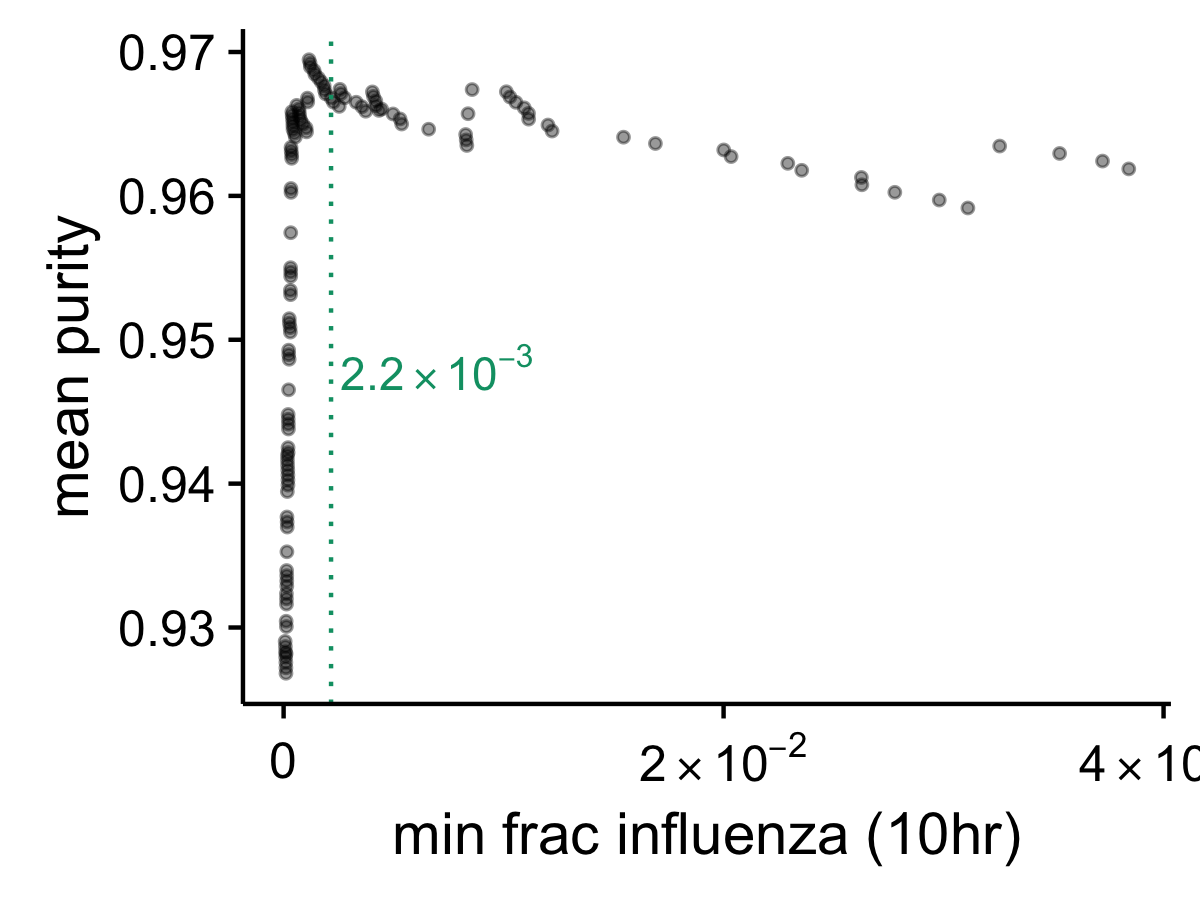

In [26]:
# get the sample with the most flu positive cells, compute purity cutoff on it
sample.most.flu <- bc.cells %>% group_by(Sample) %>% summarise(cells=n()) %>% 
  arrange(cells) %>% tail(n=1) %>% .$Sample %>% sprintf("%s", .) 
cat("Computing purity cutoff for sample with most influenza,", sample.most.flu)
bc.cells <- filter(bc.cells, Sample == sample.most.flu)

# compute purity to only out this far, as curve has flattened by about 50th percentile
frac.flu <- bc.cells$frac.flu.mRNAs %>% sort %>% head(-as.integer(0.35 * nrow(bc.cells)))

# mean of major barcode frequency with cells <= indication fraction flu
bc.cells <- mutate(bc.cells, purity=pmax(wildtype, synonymous) / (wildtype + synonymous))
purity <- data.frame(frac.flu)
purity$mean <- lapply(frac.flu, function (f) {bc.cells %>% filter(frac.flu.mRNAs > f) %>% 
  select(purity) %>% as.vector %>% unlist %>% mean}) %>% unlist

# threshold where derivative of purity with respect to fraction flu stops being positive
deriv.purity <- loess(mean~frac.flu, data=purity) %$% fitted %>% diff
i.threshold <- which(deriv.purity <= 0) %>% min  
threshold.frac <- frac.flu[i.threshold]

# plot the data and threshold line
p.purity.threshold <- ggplot(purity, 
    aes(x=frac.flu, y=mean)) + geom_point(size=1, alpha=0.4) + 
  scale_y_continuous(name="mean purity", 
    limits=c(min(purity$mean), max(purity$mean))) +
  scale_x_continuous(name=sprintf("min frac influenza (%s)", sample.most.flu), 
    labels=fancy_scientific, breaks=pretty_breaks(n=2)) +
  theme(axis.text.x=element_text(vjust=0.2)) +
  geom_vline(xintercept=threshold.frac, color=cbbPalette[[4]], linetype="dotted") + 
  annotate("text", x=threshold.frac, y=mean(c(min(purity$mean), max(purity$mean))), 
      label=fancy_scientific(threshold.frac, parse.str=FALSE, digits=2), hjust=-0.05, 
    parse=TRUE, color=cbbPalette[[4]])

saveShowPlot(p.purity.threshold, width=4, height=3)

Now we annotate cells as *infected* based on whether they have more than this threshold fraction of reads from influenza.

We also annotate cells as *coinfected* if they have **both**:

  1. More than the threshold fraction of reads from their minor barcode (where the threshold fraction is defined as the above amount giving the fraction of influenza reads needed to consider that we have a "true" infection).
  2. More than 5% of their barcoded influenza reads from their minor barcode. 
  
We also annotate cells as *fully.infected* if they are *infected* and have at least one of each influenza mRNA.

In the tabulation below, *coinfected* is a subset of *infected* (e.g., *coinfected* cells are also counted as *infected*), and *fully.infected* is a subset of *infected* and potentially also *coinfected*.
  
Note that we do not expect to identify all of the co-infected cells. 
Even if the wildtype and synonymously barcoded viruses are mixed at exactly equal ratios, we expect half of the co-infected cells to receive two of the same virus barcode, and so be undetectably co-infected.

We then plot the distribution of influenza reads per cell among the clearly infected or co-infected cells for each sample.

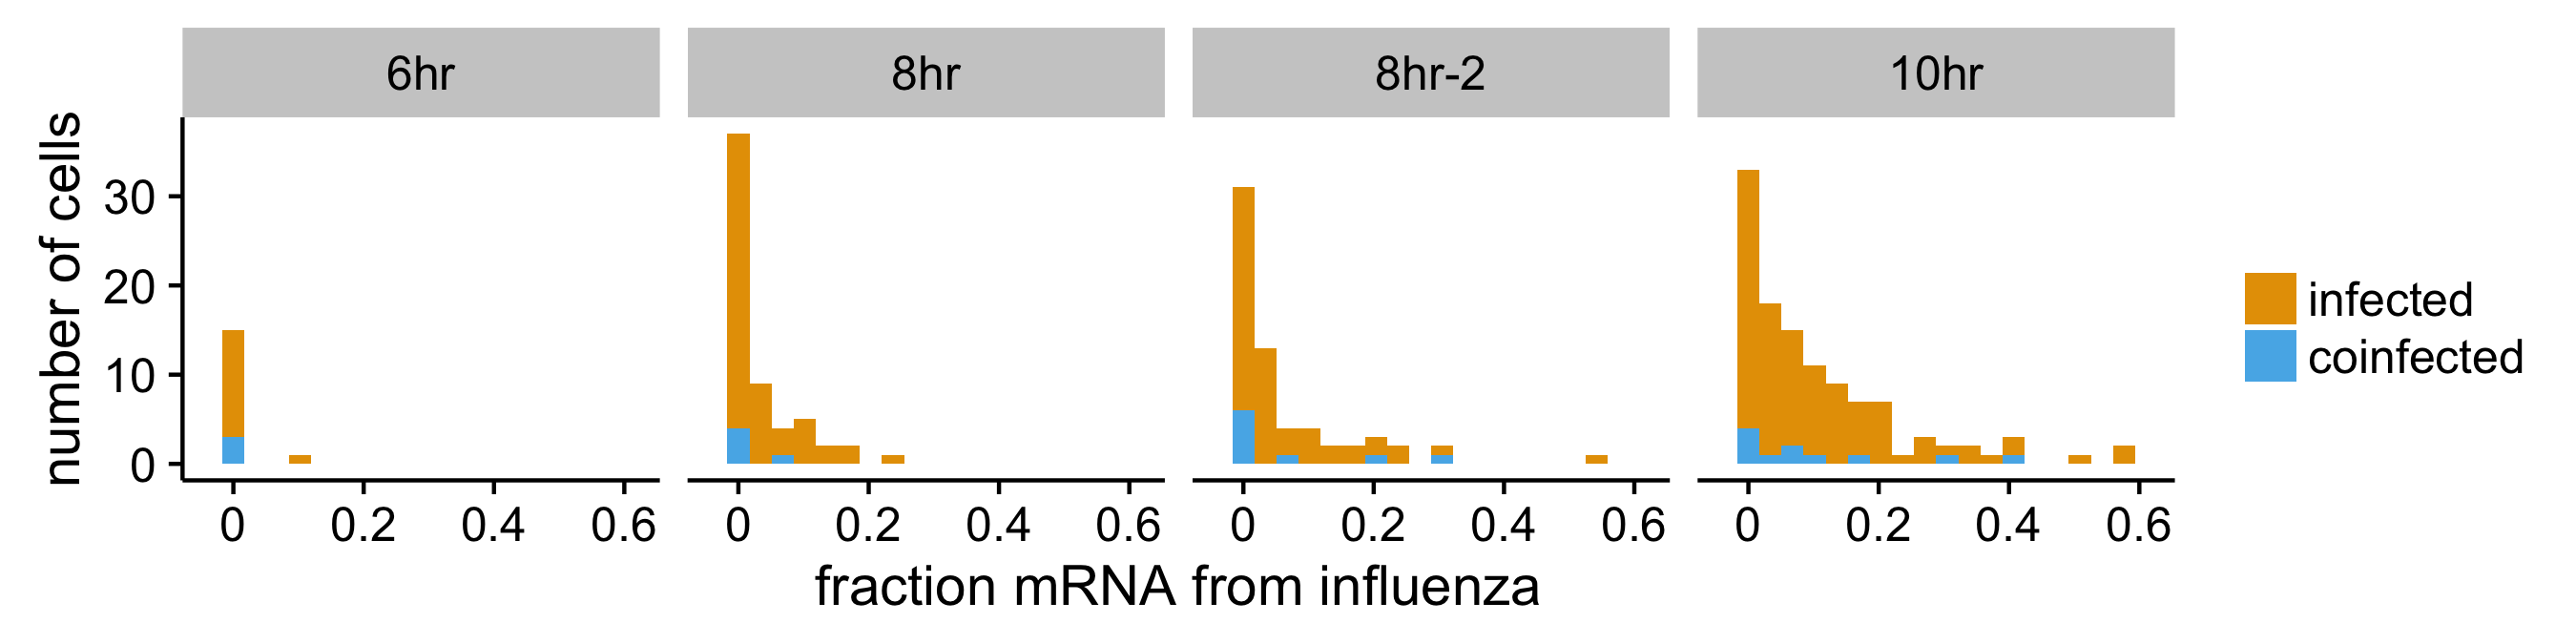

In [27]:
# annotate cells as infected or coinfected, also by whether they have any flu
coinfect.threshold <- 0.05 # coinfected requires >= this fraction minor barcode 
pData(cells)$infected <- pData(cells)$frac.flu.mRNAs > threshold.frac
pData(cells)$any.flu <- pData(cells)$frac.flu.mRNAs > 0
pData(cells)$minor <- pmin(pData(cells)$flu.wt, pData(cells)$flu.syn) /
  (pData(cells)$flu.wt + pData(cells)$flu.syn)
pData(cells)$minor <- ifelse(is.na(pData(cells)$minor), 0, pData(cells)$minor)
pData(cells)$n.minor <- pData(cells)$minor * pData(cells)$flu.mRNAs
pData(cells)$coinfected <- pData(cells)$infected & 
  (pData(cells)$minor > coinfect.threshold) & (pData(cells)$n.minor > threshold.frac)

# we also annotate cells by number of each flu mRNA and whether they are fully infected
pData(cells)$fully.infected <- pData(cells)$infected 
for (g in flugenes) {
  pData(cells)[[g]] <- Matrix::colSums(exprs(cells[
    row.names(subset(fData(cells), gene_short_name == g)),]))
  pData(cells)$fully.infected <- pData(cells)$fully.infected & as.logical(pData(cells)[[g]])
} 

# plot number of infected / co-infected cells
xlabeler <- function(x) {ifelse(x%%1, sprintf("%.1f", x), sprintf("%d", x))}
p.frac.flu <- ggplot(
    pData(cells) %>% filter(infected) %>%  
      mutate(infection=ifelse(coinfected, "coinfected", "infected")) %>%
      transform(infection=factor(infection, c("infected", "coinfected")),
        Sample=factor(Sample, samples)) %>% 
      arrange(Sample, infection), 
    aes(frac.flu.mRNAs, fill=infection)) + 
  geom_histogram(bins=18) + 
  facet_wrap(~Sample, nrow=1) + 
  scale_fill_manual("", values=cbbPalette[2:4]) +
  scale_y_continuous(name="number of cells") + 
  scale_x_continuous(name="fraction mRNA from influenza", labels=xlabeler, expand=c(0.1, 0))

saveShowPlot(p.frac.flu, width=9, height=2.25)

Related to the plot above, we will now plot the fraction of all influenza mRNA among infected cells that is attributable to a given fraction of cells.
A small fraction of cells (less than 15 percent for all samples) is responsible for over half the viral mRNA.

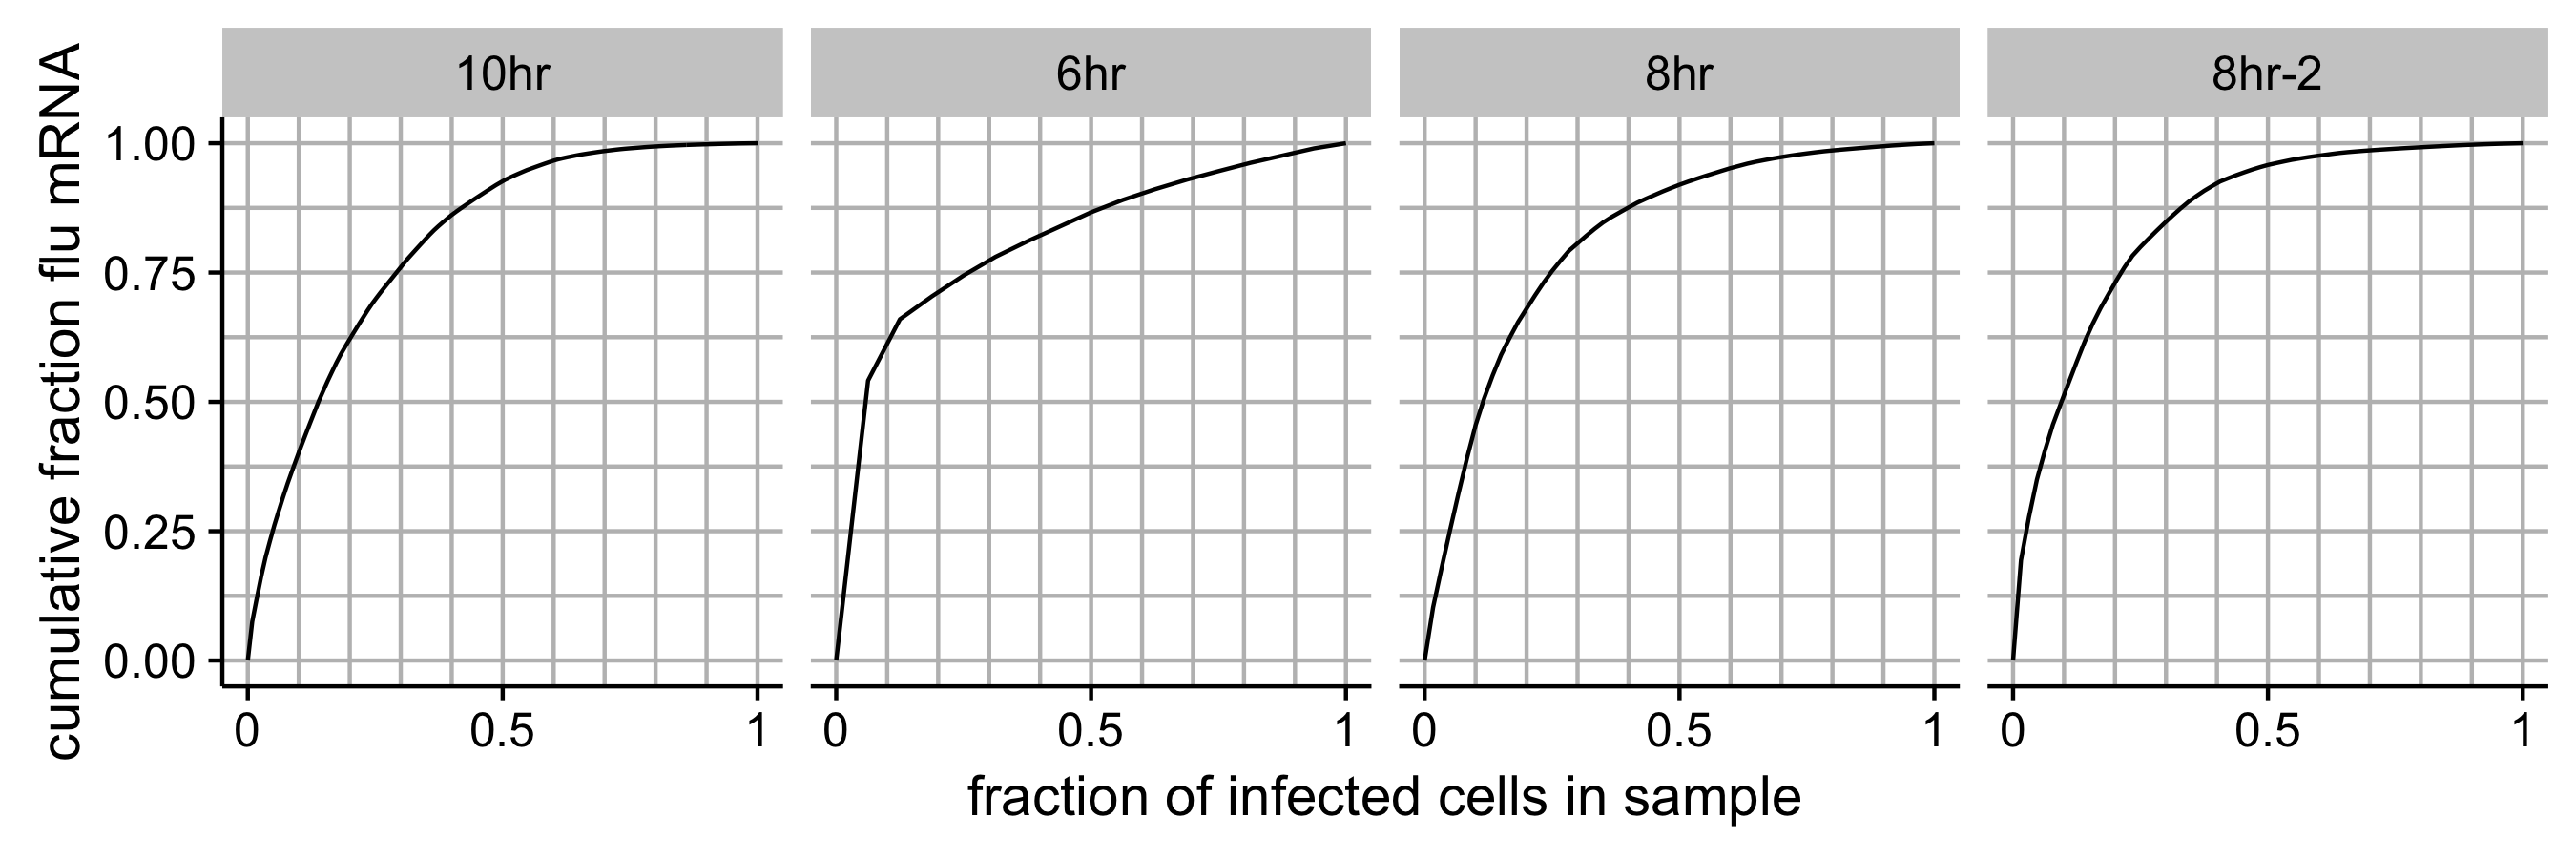

In [28]:
infected.cells <- pData(cells) %>% 
  filter(infected) %>% 
  select(flu.mRNAs, Sample) %>% 
  arrange(Sample, desc(flu.mRNAs)) %>%
  group_by(Sample) %>%
  mutate(cell.number=row_number()) %>%
  mutate(cell.frac=cell.number / n()) %>%
  mutate(sample.flu.mRNAs=sum(flu.mRNAs)) %>%
  mutate(cumul.flu.mRNAs=cumsum(flu.mRNAs)) %>%
  mutate(cumul.frac.flu.mRNAs=cumul.flu.mRNAs / sample.flu.mRNAs) %>%
  select(cell.frac, cumul.frac.flu.mRNAs, Sample) %>%
  ungroup

# add a row at zero for each sample
for (s in unique(infected.cells$Sample)) {
  infected.cells <- rbind(infected.cells,
    data.frame(cell.frac=0, cumul.frac.flu.mRNAs=0, Sample=s))
}

p.cumul.flu <- ggplot(infected.cells, aes(x=cell.frac, y=cumul.frac.flu.mRNAs)) + 
  geom_line() + 
  scale_y_continuous(name="cumulative fraction flu mRNA") +
  scale_x_continuous(name="fraction of infected cells in sample", breaks=c(0, 0.5, 1), 
    labels=c("0", "0.5", "1"), minor_breaks=seq(0, 1, 0.1)) +
  theme(panel.grid.minor=element_line(color="gray"), panel.grid.major=element_line(color="gray")) +
  facet_wrap(~Sample, nrow=1)

saveShowPlot(p.cumul.flu, width=9, height=3, isfig=TRUE)

We have a very large number of uninfected cells and a very small number of infected ones.
If we work with this entire dataset, it will therefore be heavily dominated by the uninfected cells.
We will therefore subsample the uninfected cells to get a more balanced composition of the different types of cells. 
Specifically, we subsample as follows:
  1. We keep **all** of the *infected* cells based on the threshold described above (as well as all the *coinfected* ones, which are a subset of the *infected* ones).
  2. We then keep a fraction of the *uninfected* cells. We choose the *uninfected* cells to retain for each *Sample* as follows:
    1. We set a number of *uninfected* cells to retain that is equal to the larger of the number of infected cells for that *Sample* or 50.
    2. We order the *uninfected* cells by the amount of influenza mRNA (recall that even the uninfected cells may have a bit due to leakage), and preferentially choose our cells with the lowest amount of influenza mRNA to ensure that we're getting truly uninfected cells. Usually this means that we choose cells with no influenza mRNA, although for samples with higher influenza burden there could still be a few if there aren't enough cells with no influenza mRNA.

Below we make these selections, and then tabulate the number of cells in each category.

In [29]:
# get uninfected cells to keep; first assign original row names 
uninfected.cells <- pData(cells) %>% (tibble::rownames_to_column) %>% filter(!infected)
# set seed to make reproducible, re-shuffle rows, sort so lowest flu first
set.seed(1) 
uninfected.cells <- uninfected.cells[sample(nrow(uninfected.cells)),] %>% 
  arrange(flu.mRNAs)
rows.to.keep <- c()
# now select uninfected cells for each sample
for (s in samples) {
  n <- max(50, nrow(pData(cells) %>% filter(Sample == s, infected)))
  s.rows.to.keep <- uninfected.cells %>% filter(Sample == s) %>% head(n=n) %$% rowname
  rows.to.keep <- c(rows.to.keep, s.rows.to.keep)
}

# annotate as uninfected the uninfected cells that we are keeping
pData(cells)$uninfected <- FALSE
pData(cells)[rows.to.keep, which(colnames(pData(cells)) == "uninfected")] <- TRUE

# summarize number of cells in each category by sample
infected.summary <- pData(cells) %>% group_by(Sample) %>% 
  summarise(cells=n(), infected=sum(infected), coinfected=sum(coinfected), 
    any.flu=sum(any.flu), uninfected.kept=sum(uninfected)) %>%
  mutate(coinfected=ifelse(is.na(coinfected), 0, coinfected)) %>% 
  transform(Sample=factor(Sample, samples)) %>% arrange(Sample) 
names(infected.summary) <- gsub('\\.', ' ', names(infected.summary))
infected.summary

# keep all infected cells
rows.to.keep <- c(rows.to.keep, pData(cells) %>% subset(infected) %>% row.names)

# select the cells we are keeping
cells <- cells[, rows.to.keep]

Sample,cells,infected,coinfected,any flu,uninfected kept
Uninfected,3677,0,0,0,50
6hr,3128,16,3,250,50
8hr,3293,60,5,530,60
8hr-2,3200,64,9,823,64
10hr,2826,115,11,1636,115


Finally, we merge these plots / tables with the ones aboved used to call infection / co-infection into a publication-quality figure.

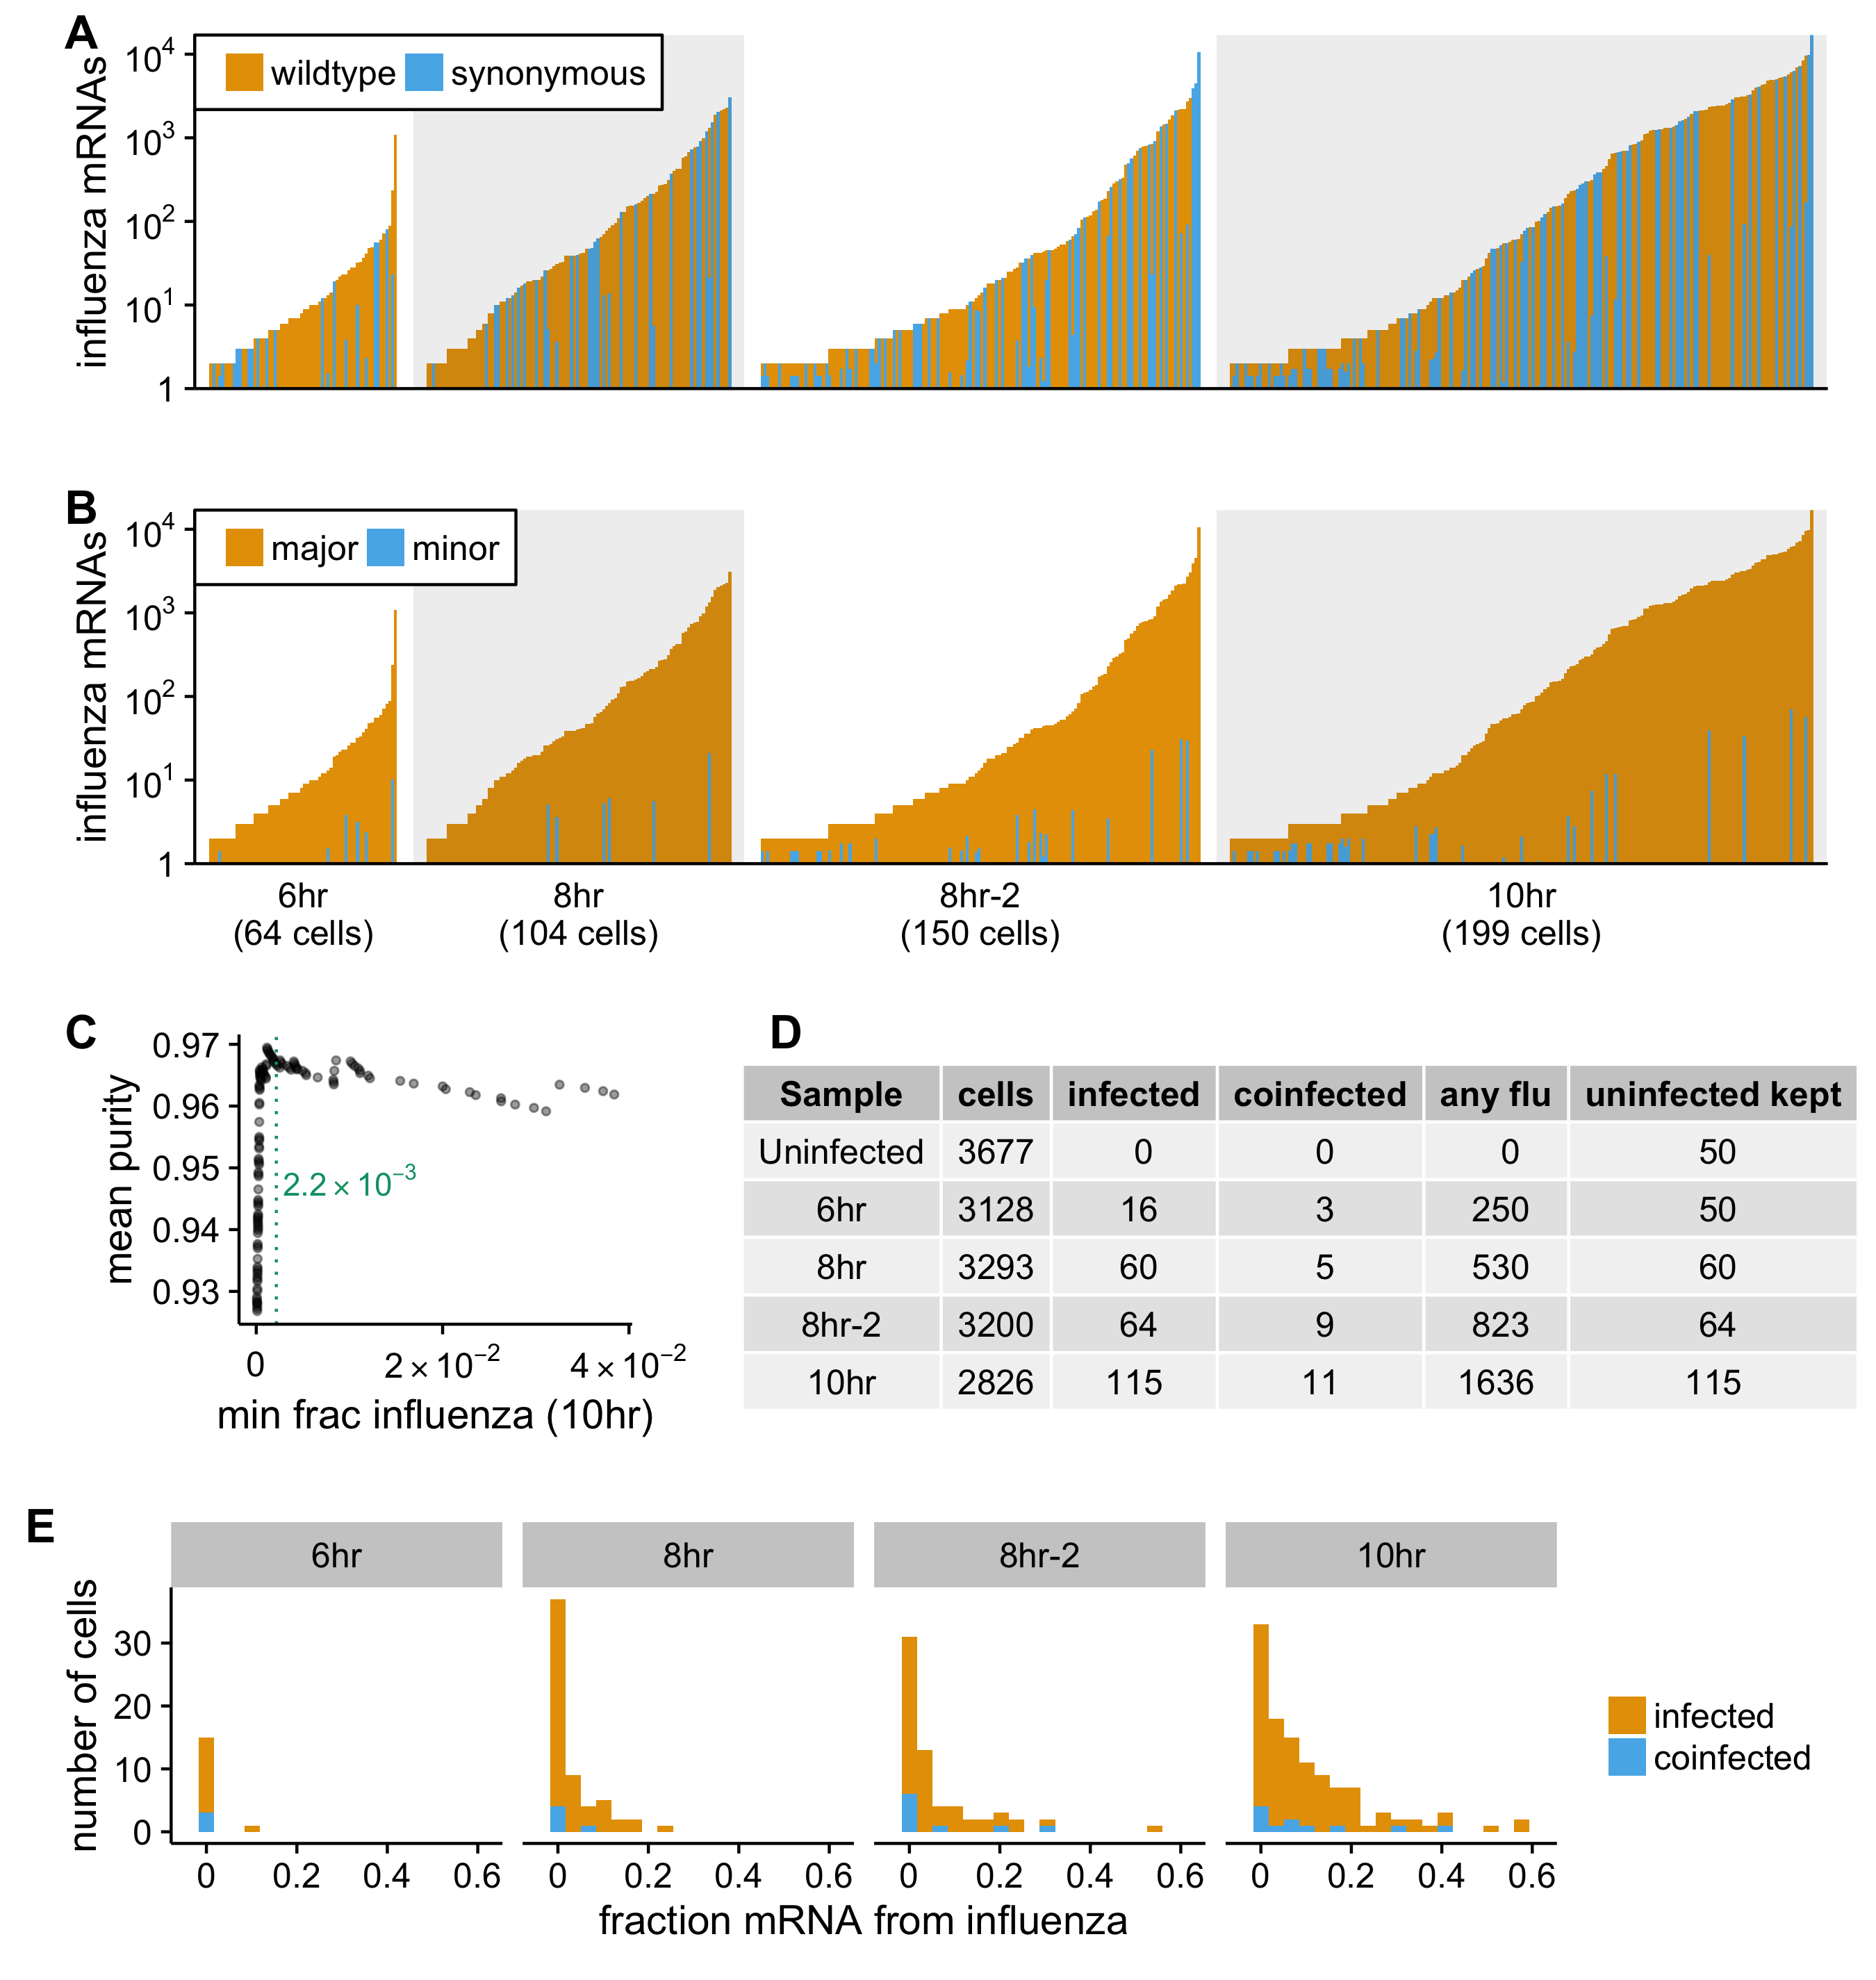

In [30]:
# blank to fill space
blank <- ggplot() + geom_blank(aes(1,1)) + theme_nothing()

# layout in one nice figure
p.frac.flu.summary <- plot_grid(
  p.barcode.purity, 
  plot_grid(p.purity.threshold, blank, infected.summary %>% tableGrob(rows=NULL), scale=0.93, 
    labels=c("C", "", "D"), label_size=16, vjust=0.5, nrow=1, rel_widths=c(0.8, 0.1, 1.4)), 
  p.frac.flu,
  labels=c("", "", "E"), label_size=16, vjust=1, ncol=1, 
  rel_heights=c(1, 0.51, 0.48), scale=0.97)

saveShowPlot(p.frac.flu.summary, width=9, height=9.5, isfig=TRUE)

## Filter the set of genes to consider further

Before we start any filtering of genes, we estimate the size factors and dispersion.
We have already filtered by cell, but that is OK to do before estimating the size factors.

In [ ]:
options(warn=-1) # suppress warnings that otherwise clutter output

cells <- estimateSizeFactors(cells)
cells <- estimateDispersions(cells)

We will only focus on genes that are expressed at a meaningful level.
First, we filter out genes that are not expressed in any cells.

In [ ]:
cells <- detectGenes(cells)
cells <- cells[row.names(subset(fData(cells), num_cells_expressed > 0)), ]

Now for each gene we get the maximum expression in any cell, and annotate whether the gene is viral or cellular.
For cellular genes, we also annotate whether it is a type I interferon based on whether the name starts with IFN.
Finally, we annotate cells by how many of these IFN mRNAs they are expressing.

In [ ]:
# get max expression in any cell
fData(cells)$max.expression <- cells %>% exprs %>% (qlcMatrix::rowMax) %>% as.double

# Annotate mRNA source as influenza, IFN, or cellular
# We look for IFN alpha, beta, and lambda but not receptors
ifngenes <- grep("^IFN[ABL][^R]", fData(cells)$gene_short_name, value=TRUE)
cat("Annotating the following genes as IFN:", ifngenes)
fData(cells)$source <- ifelse(fData(cells)$gene_short_name %in% flugenes, 
  "influenza", ifelse(fData(cells)$gene_short_name %in% ifngenes, "IFN", "cellular"))

# number of IFN mRNAs per cell
pData(cells)$IFN.mRNAs <- Matrix::colSums(exprs(cells[row.names(subset(fData(cells), 
  gene_short_name %in% ifngenes)),]))

We then plot the number of cells that express a gene versus its maximum expression. 

The [Monocle vignette](http://cole-trapnell-lab.github.io/monocle-release/) suggests only filtering for genes that are expressed in some reasonable fraction of cells.
But as is clear from the plot, below there are some genes that are substantially expressed in only a few (or in some cases even just one) cell, but are clearly biologically significant as they are either type I interferons or influenza genes. 
So instead, we filter the genes based on the **maximum** expression of a gene in any cell.
The gray line shows the filter; we only consider genes to the right of this gray line.

In [ ]:
max.expr.cutoff = 4 # only consider genes with more than this much max expression

p.maxexpr.ncells <- ggplot(fData(cells), 
    aes(max.expression, num_cells_expressed, color=source)) + 
  geom_point(alpha=0.4) + scale_x_log10(name="max expression in any cell") + 
  scale_y_log10(name="num cells expressed") +   
  geom_vline(aes(xintercept=max.expr.cutoff), color="gray40")
p.maxexpr.ncells <- ggMarginal(p.maxexpr.ncells, margins="x", color="blue") 

saveShowPlot(p.maxexpr.ncells, width=5, height=3)

cells <- cells[row.names(subset(fData(cells), max.expression > max.expr.cutoff)), ]

The [Monocle vignette](http://cole-trapnell-lab.github.io/monocle-release/) suggests verifying that the expression values follow a roughly log-normal distribution.
This next plot follows the vignette to verify that.

In [ ]:
L <- log(exprs(cells))
melted_dens_df <- melt(Matrix::t(scale(Matrix::t(L))))

p.lognormal.expr <- qplot(value, geom="density", data=melted_dens_df) + 
  stat_function(fun = dnorm, size=0.5, color='red') + 
  xlab("standardized log(mRNAs)") + ylab("density")

saveShowPlot(p.lognormal.expr, width=3, height=2)

## Classify cell types
We create a cell-type hierarchy as outlined in the [Monocle vignette](http://cole-trapnell-lab.github.io/monocle-release/).

We first create a classification for cells infected with any virus using the threshold above, then also classifications for cells with at least 2% and 20% of their reads from inlfuenza. 
We also classify as *uninfected* any cells with **no** influenza mRNAs.

In [ ]:
cth <- newCellTypeHierarchy()

flugenes.id <- row.names(subset(fData(cells), gene_short_name %in% flugenes))
cth <- addCellType(cth, "infected", classify_func=function(x) {
  Matrix::colSums(x[flugenes.id, ]) / Matrix::colSums(x) > threshold.frac})
cth <- addCellType(cth, "infected > 2%", classify_func=function(x) {
  Matrix::colSums(x[flugenes.id, ]) / Matrix::colSums(x) > 0.02},
  parent_cell_type_name="infected")
cth <- addCellType(cth, "infected > 20%", classify_func=function(x) {
  Matrix::colSums(x[flugenes.id, ]) / Matrix::colSums(x) > 0.20},
  parent_cell_type_name="infected > 2%")
cth <- addCellType(cth, "uninfected", classify_func=function(x) {
  Matrix::colSums(x[flugenes.id, ]) == 0})

Now classify the cells according to the cell type hierarchy and print out the number in each category.

In [ ]:
cells <- classifyCells(cells, cth)
table(pData(cells)$CellType)

## Unsupervised clustering of the cells
As in the [Monocle vignette](http://cole-trapnell-lab.github.io/monocle-release/), we now perform unsupervised clustering.
This does not appear to yield anything useful, but we do it anyway as tSNE plots seem to be a standard thing that people look at in single-cell experiments so someone might ask us...

First, we filter on the genes to use in the clustering. 
We use a slightly more lenient cutoff than in the [Monocle vignette](http://cole-trapnell-lab.github.io/monocle-release/) for *mean_expression=0.1*.
We then plot the dispersion versus the mean expression, and the variance explained by each component.
Next, we plot the variance explained by each component.
Finally, we make the tSNE plot while regressing out sample and number of genes for batch effect.

The resulting tSNE plot below partially separates infected and uninfected cells.

In [ ]:
options(warn=-1) # suppress warnings that otherwise clutter output

disp_table <- dispersionTable(cells)
unsup_clustering_genes <- subset(disp_table, mean_expression > 0.05)
cells <- setOrderingFilter(cells, unsup_clustering_genes$gene_id)

p.unsup.disp.vs.expr <- plot_ordering_genes(cells) + scale_x_log10(labels=fancy_scientific)

p.unsup.pc.variance <- plot_pc_variance_explained(cells, return_all=FALSE)

cells <- reduceDimension(cells, max_components=2, num_dim=6, 
  reduction_method='tSNE', verbose=FALSE, 
  residualModelFormulaStr="~Sample")
cells <- clusterCells(cells, num_clusters=2)
p.unsup.tsne <- plot_cell_clusters(cells, color="CellType") + 
  guides(color=guide_legend(ncol=1)) + theme(legend.position="right")

p.unsup.tsne.merge <- plot_grid(p.unsup.disp.vs.expr, p.unsup.pc.variance, p.unsup.tsne,  
  nrow=1, labels="AUTO", vjust=-0.2, label_size=16, align='h', scale=0.93, 
  rel_widths=c(1, 1, 1.5))

saveShowPlot(p.unsup.tsne.merge, width=10, height=3)

## Supervised clustering of the genes
Now we'll re-do the tSNE clustering but use supervised clustering as in the [Monocle vignette](http://cole-trapnell-lab.github.io/monocle-release/).
The supervised clustering visually appears somewhat than the unsupervised in terms of separating the populations. 

In [ ]:
options(warn=-1) # suppress warnings that otherwise clutter output

marker_diff <- markerDiffTable(cells, cth, 
  residualModelFormulaStr="~Sample + num_genes_expressed", cores=detectCores())

candidate_clustering_genes <- subset(marker_diff, qval < 0.01) %>% row.names
marker_spec <- calculateMarkerSpecificity(cells[candidate_clustering_genes, ], cth)
semisup_clustering_genes <- selectTopMarkers(marker_spec, 40) %$% gene_id %>% unique 
cells <- setOrderingFilter(cells, semisup_clustering_genes)

p.sup.disp.vs.expr <- plot_ordering_genes(cells) + scale_x_log10(labels=fancy_scientific)

p.sup.pc.variance <- plot_pc_variance_explained(cells, return_all=FALSE)

cells <- reduceDimension(cells, max_components=2, num_dim=6, 
  reduction_method='tSNE', verbose=FALSE, norm_method='log', 
  residualModelFormulaStr="~Sample")
cells <- clusterCells(cells, num_clusters=2)
p.sup.tsne <- plot_cell_clusters(cells, color="CellType") + 
  guides(color=guide_legend(ncol=1)) + theme(legend.position="right")

p.sup.tsne.merge <- plot_grid(p.sup.disp.vs.expr, p.sup.pc.variance, p.sup.tsne,  
  nrow=1, labels="AUTO", vjust=-0.2, label_size=16, align='h', scale=0.93, 
  rel_widths=c(1, 1, 1.5))

saveShowPlot(p.sup.tsne.merge, width=10, height=3)

We now use these tSNE plots to annotate the cells out in two ways that are visually informative.

First, we do a larger display that is annotated by all influenza genes as well as some other properties of interest.

In [ ]:
legend.gradient <- guides(color=guide_colorbar(title.position="top", title.hjust=0.5,
    barwidth=10, barheight=0.8)) 
color.gradient <- scale_color_gradientn(colors=matlab.like(40))
gray.red.gradient <- scale_color_gradient(low="grey", high="red")
legend.discrete <- guides(color=guide_legend(nrow=2, title.position="top", title.hjust=0.5))

# annotate cells with some properties 
pData(cells)$infection.level <- case_when(
  !pData(cells)$infected ~ "not infected",
  pData(cells)$frac.flu.mRNAs < 0.01 ~ "<1% flu",
  pData(cells)$frac.flu.mRNAs < 0.1 ~ "<10% flu",
  TRUE ~ ">10% flu"
  ) %>% factor(c("not infected", "<1% flu", "<10% flu", ">10% flu"))
pData(cells)$flu.completeness <- case_when(
  !pData(cells)$infected ~ "not infected",
  pmin(pData(cells)$fluPB2, pData(cells)$fluPB1, pData(cells)$fluPA, 
    pData(cells)$fluNP) == 0 ~ "lacks RNP gene",
  !pData(cells)$fully.infected ~ "lacks other gene",
  TRUE ~ "all 8 genes"
  ) %>% factor(c("not infected", "lacks RNP gene", "lacks other gene", 
    "all 8 genes"))
pData(cells)$ns.status <- case_when(
  !pData(cells)$infected ~ "uninfected",
  pData(cells)$frac.flu.mRNAs < 0.01 ~ "<1% flu",
  pData(cells)$fluNS < 2 ~ ">1% flu, no NS",
  TRUE ~ ">1% flu, has NS"
  ) %>% factor(c("uninfected", "<1% flu", ">1% flu, no NS", ">1% flu, has NS"))
pData(cells)$Sample <- factor(pData(cells)$Sample, samples)
pData(cells)$log2.IFN <- log2(pData(cells)$IFN.mRNAs + 1)
pData(cells)$IFIT1 <- Matrix::colSums(exprs(cells[row.names(subset(fData(cells), 
  gene_short_name == 'IFIT1')),]))
pData(cells)$log2.IFIT1 <- log2(pData(cells)$IFIT1 + 1)

plot_cluster <- function(gene) {
  label <- paste("log2", gene, sep=".")
  pData(cells)[gene] <- Matrix::colSums(exprs(cells[row.names(subset(fData(cells), 
    gene_short_name == gene)),]))
  pData(cells)[label] <- log2(pData(cells)[gene] + 1)
  plot_cell_clusters(cells, color=label, cell_size=1) + 
    labs(color=paste("log2(", gsub("flu", "", gene), " + 1)", sep="")) + 
    legend.gradient + color.gradient  
  }

p.tsne.sample <- plot_cell_clusters(cells, color="Sample", cell_size=1) + 
    labs(color="Experimental sample") + legend.discrete
p.tsne.frac.flu <- plot_cell_clusters(cells, color="frac.flu.mRNAs", cell_size=1) + 
    labs(color="fraction mRNA from flu") + legend.gradient + color.gradient
  
      
p.big.tsne.list <- c(list(p.tsne.sample, p.tsne.frac.flu),
  lapply(c(flugenes, "IFIT1"), plot_cluster),
  list(plot_cell_clusters(cells, color="log2.IFN", cell_size=1) + 
    labs(color="log2(IFN mRNAs + 1)") + legend.gradient + color.gradient))

# make a merged plot showing all the flu genes
p.big.tsne.merge <- plot_grid(plotlist=p.big.tsne.list, 
  ncol=4, labels="AUTO", vjust=0, label_size=16, align='h', scale=0.93)
saveShowPlot(p.big.tsne.merge, width=12, height=12, isfig=TRUE)

Next we do a somewhat smaller layout where we show just a few properties of greatest interest.

In [ ]:
# Make a list of plots each colored by some property of interest.
p.small.tsne.list <- list(
  p.tsne.frac.flu + gray.red.gradient,
  plot_cell_clusters(cells, color="infection.level", cell_size=1) + 
    labs(color="fraction mRNA from flu") + legend.discrete +
    scale_color_manual(values=rev(cbbPalette[1:4])),
  p.tsne.sample + scale_color_manual(values=rev(cbbPalette[1:5])),
  plot_cell_clusters(cells, color="log2.IFN", cell_size=1) + 
    labs(color="log2(IFN mRNAs + 1)") + legend.gradient + gray.red.gradient,
  plot_cell_clusters(cells, color="log2.IFIT1", cell_size=1) + 
    labs(color="log2(IFIT1 mRNAs + 1)") + legend.gradient + gray.red.gradient,
  plot_cell_clusters(cells, color="ns.status", cell_size=1) +
    labs(color="flu NS gene detected") + legend.discrete + 
    scale_color_manual(values=rev(cbbPalette[1:4])) 
  )
                          
# make a smaller merged plot just showing some properties of interest
p.small.tsne.merge <- plot_grid(plotlist=p.small.tsne.list, 
  nrow=2, labels="AUTO", vjust=0, label_size=16, align='h', scale=0.93)
saveShowPlot(p.small.tsne.merge, width=10, height=8.5, isfig=TRUE)

The first two panels in the plot above simply show that the layout roughly corresponds to influenza burden in the cells.
The next panel shows that although later timepoints tend to have more infection burden, there are also early timepoints with high burden and late timepoints with low burden.
This indicates that our cells do **not** simply cluster by sample.

The final three panels deal with interferon induction.
The first of these panels shows expression of type I and III IFN genes as classified above.
Basically, just a **single** cell has strong IFN induction.
The next panel shows expression of IFIT1, which is an interferon-stimulated gene. 
Here we see a bit of expression on several cells, perhaps indicating weak paracrine signaling.
The final panels shows that the strong IFN induction is an NS-deficient virus, which makes sense as NS1 is influenza's IFN antagonist.
However, there are also lots of cells with high influenza burden and no NS that do not express IFN.

## Examine how influenza burden varies with expression of influenza genes and define presence/absence of segments
Here we look more rigorously to see how the influenza burden depends on the expression of influenza genes.

First, we plot the fraction of each cells mRNA from influenza as a function of the **normalized** expression of each influenza gene. 
These plots are below.
It is apparent that cells with more overall influenza mRNA express more of each gene on average.
For the RNP genes, it appears that cells that have high influenza expression always have more of these genes -- an expected result since they are needed for secondary transcription.
For the other genes, cells with high influenza expression usually have more of these genes, but there are exceptions.

The same thing is generally true if we look at the samples individually rather than together.

In [ ]:
options(warn=-1) # suppress warnings that otherwise clutter output

flugenes.noprefix <- c("PB2", "PB1", "PA", "NP", "HA", "NA", "M", "NS")

plot_flu_burden_by_gene <- function(sample.subset, title) {
  # get just flu genes in infected cells
  flu.subset <- cells[row.names(subset(fData(cells), gene_short_name %in% flugenes)), 
  row.names(subset(pData(cells), infected & (Sample %in% sample.subset)))]
  # rename and order flu genes
  fData(flu.subset)$gene_short_name <- gsub("flu", "", fData(flu.subset)$gene_short_name) %>%
    factor(flugenes.noprefix) 
  # plot flu burden by relative expression of flu gene
  p <- plot_genes_jitter(flu.subset, grouping="frac.flu.mRNAs", ncol=4, 
      color_by="flu.completeness", cell_size=1.5) + 
    theme(legend.position='top') + labs(color='fraction mRNA from flu:') + 
    scale_x_continuous("fraction mRNA from flu") + scale_y_log10("relative expression") +
    scale_color_manual(values=cbbPalette) 
  if (title) {
    p <- p + ggtitle(sample.subset[1]) + guides(color=FALSE) + 
      scale_x_continuous("fraction mRNA from flu", breaks=scales::pretty_breaks(n=3))
  } else {
    p <- p + guides(color=guide_legend(nrow=1)) 
  }
}

# make plot for all samples
p.flu.burden.flu.gene <- plot_flu_burden_by_gene(samples, title=FALSE)
saveShowPlot(p.flu.burden.flu.gene, width=9, height=5)

# make plot for individual samples
flu.burden.flu.gene.list <- lapply(c(c("10hr"), c("8hr-2"), c("8hr")), 
  plot_flu_burden_by_gene, title=TRUE)
p.flu.burden.flu.gene.by.sample <- plot_grid(plotlist=flu.burden.flu.gene.list,
  ncol=1, labels="AUTO", label_size=16, align='h', scale=0.98)
saveShowPlot(p.flu.burden.flu.gene.by.sample, width=9, height=12, isfig=TRUE)

Based on the plots above, we now undertake a more rigorous examination of whether the total influenza burden depends on the presence / absence of each gene.

We consider an influenza gene to be present if it is detected at least once in a cell, and we limit our analysis to cells with at least 0.5% influenza infection to avoid noise from cells with very low infection.
We use a Wilcoxon test to examine if there is more or less influenza infection in cells with / without each gene.
As expected, we see that presence of all the RNP genes (PB2, PB1, PA, NP) is strongly associated with high influenza burden -- this makes sense, as only cells with all these genes can undergo secondary transcription.
Perhaps less expected, we see that there is no association between influenza burden and the other genes.
This fact perhaps suggests that whatever function the non-RNP genes have in regulating the RNP and host cell, these aren't very important for efficient viral transcription.

We also make a version of the sample plot for the *10hr* sample only. 
Although the difference is no longer statistically significant for NP (presumably due to fewer counts of cells with no NP), the trends are exactly the same as for all samples combined.
We don't do the other samples as they have too few cells to try to get statistics individually.

In [ ]:
# make data frame annotating whether cells have reads from each segment
flu.df <- pData(cells) %>% 
  filter(infected, frac.flu.mRNAs > 0.005) %>% 
    mutate(log.frac.flu=log10(frac.flu.mRNAs))
for (g in flugenes) {
  flu.df[[gsub("flu", "", g)]] <- ifelse(flu.df[[g]] > 0, "yes", "no")
} 

m <- melt(flu.df, id='frac.flu.mRNAs', measure.vars=flugenes.noprefix) 
  
p.flu.burden.flu.gene.test <- ggplot(data=m, aes(variable, frac.flu.mRNAs)) + 
  geom_boxplot(aes(fill=value), outlier.color='gray50', outlier.alpha=0.4, 
    width=0.6, position=position_dodge(0.7)) +
  scale_y_continuous(name='fraction mRNA from flu') + 
  scale_x_discrete(name='influenza gene') + 
  guides(fill=guide_legend(title='cell has gene:')) + theme(legend.position='top') +
  stat_compare_means(aes(group=value), label="p.signif", method='wilcox.test')

saveShowPlot(p.flu.burden.flu.gene.test, width=9, height=3.5)

# we also make the same plot for just the 10hr sample
flu.df.10hr <- flu.df %>% filter(Sample == "10hr")
m.10hr <- melt(flu.df.10hr, id='frac.flu.mRNAs', measure.vars=flugenes.noprefix) 
  
p.10hr.flu.burden.flu.gene.test <- ggplot(data=m.10hr, aes(variable, frac.flu.mRNAs)) + 
  geom_boxplot(aes(fill=value), outlier.color='gray50', outlier.alpha=0.4, 
    width=0.6, position=position_dodge(0.7)) +
  scale_y_continuous(name='fraction mRNA from flu') + 
  scale_x_discrete(name='influenza gene') + 
  guides(fill=guide_legend(title='cell has gene:')) + theme(legend.position='top') +
  stat_compare_means(aes(group=value), label="p.signif", method='wilcox.test') +
  ggtitle("10hr sample only")

saveShowPlot(p.10hr.flu.burden.flu.gene.test, width=9, height=3.5, isfig=TRUE)

We look at the fraction of influenza-infected cells that are missing viral genes.
We limit this analysis to cells that are expressing **all** of the RNP genes (PB2, PB1, PA, and NP), since only those cells typically have enough viral mRNA to confidently call presence-absence of other genes.

We then examine how many cells are missing each of the other four genes, as well as missing **any** of the four.
Finally, we compute the expected fraction missing any of the four based on multiplying the fractions with all four individually.
These predicted fractions are similar to the observed, indicating segment absence is roughly independent.

In [ ]:
# examine how many cells with all RNP genes are missing each other genes
missing.genes <- pData(cells) %>% 
  select(flugenes, Sample) %>%
  mutate(hasRNP=(fluPB2 & fluPB1 & fluPA & fluNP)) %>%
  filter(hasRNP) %>% 
  group_by(Sample) %>%
  summarise(n.cells=n(), 
            has.HA=sum(fluHA>0) / n(), 
            has.NA=sum(fluNA>0) / n(), 
            has.M=sum(fluM>0) / n(), 
            has.NS=sum(fluNS>0) / n(), 
            has.all=sum((fluHA>0) & (fluNA>0) & (fluM>0) & (fluNS>0)) / n()) %>%
  mutate(pred.has.all=has.HA * has.NA * has.M * has.NS)

missing.genes
write.csv(missing.genes, file=file.path(figsdir, "p_missing_genes.csv"), quote=FALSE)

m <- missing.genes %>% filter(Sample %in% c("8hr", "8hr-2", "10hr")) %>%
  melt(missing.genes,
    id.vars="Sample", 
    measure.vars=c("has.HA", "has.NA", "has.M", "has.NS", "has.all", "pred.has.all"),
    variable.name="gene")
p.missing.genes <- ggplot(m, aes(x=gene, y=value)) + 
  geom_point(aes(color=gene), size=2.5) + 
  scale_x_discrete(name=NULL, labels=NULL) +
  scale_color_hue(labels=c("HA", "NA", "M", "NS", "all 4", "all 4 predicted")) +
  scale_y_continuous(limits=c(0, 1), name="frac cells expressing\nRNP and this gene") +
  facet_wrap(~Sample) + 
  theme(legend.position="bottom") +
  labs(color="gene(s):") + 
  guides(color=guide_legend(nrow=1)) 
saveShowPlot(p.missing.genes, width=6.5, height=2.5, isfig=TRUE)

Finally, we merge these three plots into a publication quality figure.

In [ ]:
p.flu.burden.flu.gene.merge <- plot_grid(p.flu.burden.flu.gene, p.flu.burden.flu.gene.test, p.missing.genes,
  ncol=1, labels="AUTO", label_size=16, align='h', scale=0.93, rel_heights=c(1.5, 1, 1))

saveShowPlot(p.flu.burden.flu.gene.merge, width=9, height=10, isfig=TRUE)

## Look at relative expression of influenza genes
We also look at the relative expression of influenza genes in highly infected cells.
To do this, we look at the fraction of viral mRNAs that come from each influenza gene in each cell, limiting ourselves to cells expressing at least 5% of their mRNAs from influenza.

We plot both the distribution of viral expression for each cell, and the median and distribution over all cells.

In [ ]:
# only consider cells with at least a minimum fraction of mRNA from influenza
min.flu.frac <- 0.05 
flu.expr <- pData(cells) %>% filter(frac.flu.mRNAs > min.flu.frac)

# sort cells by fraction of mRNA from influenza
sorted.barcodes <- flu.expr %>% arrange(frac.flu.mRNAs) %$% CellBarcode %>% factor
flu.expr$CellBarcode <- factor(flu.expr$CellBarcode, factor(sorted.barcodes))

plot.flu.expr <- function(df, csvfile, labels) {
  # plot fraction of *viral* mRNAs from each flu gene
  flu.expr.total <- df
  for (g in flugenes) {
    flu.expr.total[[gsub("flu", "", g)]] <- df[[g]] / df$total.mRNAs    
  }

  m.total <- flu.expr.total %>% arrange(frac.flu.mRNAs) %>% 
    melt(id.vars=c('CellBarcode'), 
    measure.vars=c(flugenes.noprefix), variable.name='gene')

  p.flu.expr.total <- ggplot(m.total, aes(x=CellBarcode, y=value)) + 
    geom_bar(aes(fill=gene), position=position_fill(reverse=TRUE), stat='identity') +
    scale_x_discrete(labels=NULL, name='cells ordered by viral burden') +
    scale_y_continuous(name='fraction of viral mRNA') +
    theme(axis.ticks.x=element_blank()) 

  flu.expr.viral <- df 
  for (g in flugenes) {
    flu.expr.viral[[gsub("flu", "", g)]] <- df[[g]] / df$flu.mRNAs
  }
  m.viral <- flu.expr.viral %>% arrange(frac.flu.mRNAs) %>%
    melt(id.vars=c("CellBarcode", "frac.flu.mRNAs"),
      measure.vars=flugenes.noprefix, variable.name='gene', value.name='frac.flu.from.gene') %>%
      group_by(gene) %>% 
      mutate(median.frac.flu.from.gene=median(frac.flu.from.gene)) %>% ungroup
  write.csv(m.viral, file=file.path(figsdir, csvfile), quote=FALSE)
  p.flu.expr.viral <- ggplot(m.viral, aes(x=gene, y=frac.flu.from.gene)) + 
    geom_boxplot(aes(fill=gene), outlier.alpha=0.3, notch=TRUE) + 
    scale_y_continuous(name='fraction of viral mRNA') + guides(fill=FALSE) 

  p.flu.expr <- plot_grid(p.flu.expr.total, p.flu.expr.viral,  
    ncol=2, labels=labels, vjust=0.2, label_size=16, align='h', scale=0.95, rel_widths=c(1.3, 1))
  p.flu.expr
}

cat("There are", nrow(flu.expr), "cells with >5% flu mRNA, of which",
  nrow(flu.expr %>% filter(fully.infected)), "have at least one molecule of each gene.")
p.all <- plot.flu.expr(flu.expr, 'p_flu_expr_all.csv', labels=c("A", "B"))
title.all <- ggdraw() + draw_label("all cells with >5% of mRNA from flu", fontface="bold")
p.fully.infected <- plot.flu.expr((flu.expr %>% filter(fully.infected)), 
  'p_flu_expr_fullyinfected.csv', labels=c("C", "D"))
title.fully.infected <- ggdraw() + 
  draw_label("cells with >5% of mRNA from flu and that express all eight viral genes", fontface="bold")
p.flu.expr <- plot_grid(title.all, p.all, title.fully.infected, p.fully.infected, 
  ncol=1, rel_heights=c(0.1, 1, 0.1, 1))
saveShowPlot(p.flu.expr, width=9, height=6.5, isfig=TRUE)

## Look at co-infection
We identify all highly infected cells (at least 5% of their mRNAs from influenza) that are also co-infected.
For each of these cells, we plot the log number of reads from each viral segment.
We color the bars showing the log number reads in linear proportion to the fraction of the reads from each viral barcode, so that a bar that is equally colored with both colors indicates equal proportions of the two barcoded viruses for that gene.

In [ ]:
min.flu.frac <- 0.05

# extract cells coinfected cells
coinfect.cells <- pData(cells) %>% 
  filter(frac.flu.mRNAs > min.flu.frac, coinfected)  
cat(nrow(coinfect.cells), "of", 
  pData(cells) %>% filter(frac.flu.mRNAs > min.flu.frac) %>% nrow, 
  "cells with >", min.flu.frac, "of their mRNAs from influenza are coinfected")

# melt into dataframe with total reads and fraction wt / syn barcode for each gene
# data frame with total reads
m.total <- coinfect.cells %>% 
  melt(id.vars=c('CellBarcode', 'frac.flu.mRNAs', 'minor'), 
    measure.vars=flugenes, variable.name='gene', value.name='reads') 
# data frame with wildtype barcode reads
m.wt <- coinfect.cells %>% 
  melt(id.vars=c('CellBarcode'), 
    measure.vars=lapply(flugenes, function (g) {sprintf("%s.wt", g)}), 
    variable.name='gene', value.name='wt.reads') %>% 
  mutate(gene=gsub('.wt', '', gene))
# data frame with synonymous barcode reads
m.syn <- coinfect.cells %>% 
  melt(id.vars='CellBarcode', 
    measure.vars=lapply(flugenes, function (g) {sprintf("%s.syn", g)}), 
    variable.name='gene', value.name='syn.reads') %>% 
  mutate(gene=gsub('.syn', '', gene))
# merged data frame with fraction of each barcode
m <- m.total %>% merge(m.wt) %>% merge(m.syn) %>%
  mutate(gene=gsub("flu", "", gene)) %>% 
  transform(gene = factor(gene, flugenes.noprefix)) %>%
  rename(cell.minor.frac = minor, cell.frac.flu = frac.flu.mRNAs) %>%
  arrange(cell.frac.flu, gene) %>%
  mutate(wt.frac = wt.reads / (wt.reads + syn.reads), 
         syn.frac = syn.reads / (wt.reads + syn.reads),
         minor.frac = pmin(wt.frac, syn.frac)) %>%
  select(-wt.reads, -syn.reads)
m %>% write.csv(file=file.path(figsdir, 'p_coinfection.csv'), quote=FALSE)

# tweak data frame for plotting by melting to separate columns for each barcode
m.plot <- m %>% 
  mutate(cell.name = sprintf('cell with %.1f%% flu', 100 * cell.frac.flu),
         wildtype = log10(reads) * wt.frac,
         synonymous = log10(reads) * syn.frac) %>%
  melt(id.vars=c('cell.name', 'gene'), measure.vars=c('wildtype', 'synonymous'),
    variable.name='barcode', value.name='log10.reads')
sorted.cells <- m.plot$cell.name %>% unique %>% naturalsort
m.plot <- m.plot %>% transform(cell.name = factor(cell.name, sorted.cells))

# make sure cell.name for plotting is unique
stopifnot((m$CellBarcode %>% unique %>% length) == (m.plot$cell.name %>% unique %>% length))

# make the plot
p.coinfection <- ggplot(m.plot, aes(x=gene, y=log10.reads, fill=barcode)) +
  geom_bar(stat='identity', position='stack') +
  coord_flip() + 
  scale_y_continuous(name='viral mRNAs detected', labels=function(y){fancy_scientific(10**y)}) + 
  guides(fill=guide_legend(title='barcode:')) +
  theme(legend.position='top', axis.text.x=element_text(vjust=0.1)) +
  facet_wrap(~cell.name, ncol=5)
saveShowPlot(p.coinfection, width=9, height=4.4, isfig=TRUE)

## Find cellular genes that vary with influenza burden
We look for cellular genes that differ in expression as a function of influenza burden.

First we have to figure out how to do the test.
We try doing this differential gene expression test in several ways:
1. A differential gene expression test on all genes after regressing out the *Sample*.
2. A differential gene expression test with *Size Factors* estimated after **excluding** influenza mRNAs. The rationale is to avoid trivial trends due to fewer relative cellular mRNAs when some mRNAs come from influenza. Computing *Size Factors* only on the cellular mRNA pool should control for this.
3. A differential gene expression test on all genes but looking at only **full infected** cells (all 8 viral mRNAs observed). The rationale is to avoid differences in influenza burden due to incomplete infection and concentrate on factors not explained by the simple absence of viral genes.
4. A differential gene expression test with *Size Factors* estimated after excluding influenza mRNAs and only looking at fully infected cells. *A priori*, this seems like the most conservative and probably the best test.
5. An additional concern is that the highly skewed distribution of influenza mRNAs per cell might make the few most highly infected cells contribute disproportionately. So we also do a test where we put a *ceiling* on the influenza fraction mRNAs per cell, assigning any cell with >25% just a value of 25% so that these top few cells don't contribute disproportionately.

Note that we perform the test **only** on the cellular genes, since we already know that levels of influenza genes vary with influenza burden.

All of these conditions make the next code cell get pretty complicated, but the basic idea is that we want to make sure that the genes we identify are fairly robust to the considerations described above.

In [ ]:
diff.expr <- fData(cells) # will hold Q values calculated in each way described above

cellular.genes <- row.names(subset(fData(cells), !(gene_short_name %in% flugenes)))

diff.expr$all.cells <- differentialGeneTest(cells[cellular.genes, ],
  fullModelFormulaStr="~Sample + frac.flu.mRNAs", 
  reducedModelFormulaStr="~Sample")[row.names(diff.expr), ]$qval

noflu.SF <- estimateSizeFactors(cells[cellular.genes, ])$Size_Factor
cells.noflu.SF <- cells
cells.noflu.SF$Size_Factor <- noflu.SF
diff.expr$all.cells.nofluSizeFactor <- differentialGeneTest(cells.noflu.SF[cellular.genes, ], 
  fullModelFormulaStr="~Sample + frac.flu.mRNAs", reducedModelFormulaStr="~Sample")[
  row.names(diff.expr), ]$qval

cells.fullinfect <- cells[, row.names(subset(pData(cells), fully.infected))]
diff.expr$fully.infected <- differentialGeneTest(cells.fullinfect[cellular.genes, ], 
  fullModelFormulaStr="~Sample + frac.flu.mRNAs", reducedModelFormulaStr="~Sample")[
  row.names(diff.expr), ]$qval

cells.fullinfect.noflu.SF <- cells.noflu.SF[,
  row.names(subset(pData(cells), fully.infected))]
diff.expr$fully.infected.nofluSizeFactor <- differentialGeneTest(
  cells.fullinfect.noflu.SF[cellular.genes, ], 
  fullModelFormulaStr="~Sample + frac.flu.mRNAs", reducedModelFormulaStr="~Sample")[
  row.names(diff.expr), ]$qval 

pData(cells.fullinfect.noflu.SF)$ceil.frac.flu.mRNAs <- pmin(
  pData(cells.fullinfect.noflu.SF)$frac.flu.mRNAs, 0.25)
test.ceil <- differentialGeneTest(
  cells.fullinfect.noflu.SF[cellular.genes, ], 
  fullModelFormulaStr="~Sample + ceil.frac.flu.mRNAs", reducedModelFormulaStr="~Sample")[
  row.names(diff.expr), ]
# save P values since this will turn out to be preferred test used for gene-set enrichment
diff.expr$ceil.fully.infected.nofluSizeFactor <- test.ceil$qval
diff.expr$P <- test.ceil$pval 

Now we want to see how well these different methods overlap in the set of genes that they return.
For ease of plotting, we put a lower floor on our Q-values and plot anything with Q < 0.001 as just 0.001.

In [ ]:
options(warn=-1) # suppress warnings that otherwise clutter output

diff.expr.methods <- c("all.cells", "all.cells.nofluSizeFactor", "fully.infected", 
    "fully.infected.nofluSizeFactor", "ceil.fully.infected.nofluSizeFactor")

diff.expr$Qsig <- ifelse(diff.expr$ceil.fully.infected.nofluSizeFactor < 0.1, 
  "< 0.1", "> 0.1")

m <- melt(diff.expr, id=c("gene_short_name", "Qsig"),
  measure.vars=diff.expr.methods)
m$value <- log10(pmax(0.001, m$value))
  
p.diff.expr.Q <- ggplot(data=m, aes(x=value, fill=Qsig)) + 
  geom_histogram() + scale_x_reverse("log10(Q)") + scale_y_continuous("number of genes") + 
  facet_wrap(~variable, nrow=1) +#+ scale_fill_discrete("") + 
  theme(legend.position="top")

saveShowPlot(p.diff.expr.Q, width=14, height=4)

As the plot above makes clear:
1. The most conservative approach is to:
  1. Restrict to only fully infected cells (the rationale being that in other cells the differences may be due mostly to viral genetics)
  2. Compute the size factors computed without influenza reads so we don't get distortion due to heavily infected cells having fewer of all genes.
  3. Place a ceiling on the fraction of influeza mRNAs of more than 0.25 is just assigned a value of 0.25 for the analysis. This probably reduces the effects of a few high-infection outlier cells.
2. Most (although not all) of the genes found using this most conservative approach are also found at Q < 0.1 by the other approaches.

For these reasons, it seems reasonable to focus on just the genes found using this most conservative method: genes differentially expressed in "fully infected" cells, with the size factors computed **without** the influenza mRNAs.
The hope is that these are genes that co-vary with differences in influenza transcriptional output due to some reason other than just differences due to some viral infections lacking certain genes.

First we plot these genes with Q < 0.1 in a heatmap. 
In order to do this using Monocle's *plot_pseudotime_heatmap* function, we have to do a hacky re-name of the *Pseudotime* attribute to the fraction of influenza mRNAs that we actually regressed against.

In [ ]:
sig.genes <- row.names(subset(diff.expr, Qsig == '< 0.1')) 
sig.cells <- cells.fullinfect.noflu.SF[sig.genes, ]
pData(sig.cells)$Pseudotime <- pData(sig.cells)$ceil.frac.flu.mRNAs
p.cellular.heatmap <- plot_pseudotime_heatmap(sig.cells, show_rownames=TRUE, return_heatmap=TRUE)

# save heatmap to PDF files as here
save_pheatmap_pdf <- function(x, filename, width=5, height=6) {
   pdf(filename, width=width, height=height)
   grid::grid.newpage()
   grid::grid.draw(x$gtable)
   dev.off()
}
pdfname <- 'p_cellular_heatmap.pdf'
save_pheatmap_pdf(p.cellular.heatmap, file.path(plotsdir, pdfname))
save_pheatmap_pdf(p.cellular.heatmap, file.path(figsdir, pdfname))

We also write these genes to a CSV file with the Q-value indicating that calculated using our preferred most-conservative approach.

In [ ]:
diff.expr %>% mutate(Q = ceil.fully.infected.nofluSizeFactor) %>%
  filter(Q < 0.1) %>% arrange(Q) %>% 
  select(gene_short_name, gene_long_name, Q, num_cells_expressed, max.expression) %>%
  write.csv(file=file.path(figsdir, 'p_sig_cellular_genes.csv'), quote=FALSE)

Above we looked at individual genes that are enriched at a Q-value of < 0.1.

We can also do a gene-set enrichment for categories of genes that are enriched. 
We do this using the [piano](https://bioconductor.org/packages/release/bioc/html/piano.html).
The gene-set collection is the *hallmark gene set with gene symbols* (file `h.all.v6.0.symbols.gmt`) from [GSEA](http://software.broadinstitute.org/gsea/index.jsp).

We run the gene-set analysis exactly as in the [piano vignette](http://www.bioconductor.org/packages/release/bioc/vignettes/piano/inst/doc/piano-vignette.pdf).
The results are shown below.
Note that piano provides some ways to make network visualizations of the enriched gene sets.
However, in our case, not very much is enriched -- there are just two pathways enriched at borderline significance of around 0.05 after adjusting the P values.
So making the networks visualization is not that useful.
Of interest, the strongest signal is for reactive oxygen species, with 27 genes and an adjusted P-value of about 0.05.

The summary results of the gene-set analysis are printed below and written to a file.

In [ ]:
gsc <- loadGSC('data/gene_ontology/h.all.v6.0.symbols.gmt')
pval <- diff.expr %>% arrange(P) %>% select(gene_short_name, P) %>% filter(!is.na(P)) %>%
  column_to_rownames(var="gene_short_name") 
gsaRes <- runGSA(pval, gsc=gsc, geneSetStat='fisher', nPerm=1e5)
gsaRes %>% GSAsummaryTable(save=TRUE, file=file.path(figsdir, 'p_pathway_enrichment.tsv')) %>% 
  arrange(`p adj (non-dir.)`) %>% head(n=10)

We are now going to try one **additional** way of looking for differentially expressed genes suggested by Cole.
This is related to the still incompletely resolved question of whether the *Size Factors* should be computed with or without influenza.
In this approach, we just make the size factors a component of the regression.
Specifically, we compare
`expr ~ flu.mRNAs + cellular.mRNAs + Sample`
to the null model
`expr ~ cellular.mRNAs + Sample`
with all *Size Factors* set to one.
We apply this test to the *fully infected* (all 8 segments) cells.

The results of this analysis is below:

In [ ]:
cells.no.SF <- cells[, row.names(subset(pData(cells), fully.infected))]
cells.no.SF$Size_Factor <- 1

results <- differentialGeneTest(cells.no.SF[cellular.genes, ],
  fullModelFormulaStr="~flu.mRNAs + cellular.mRNAs + Sample",
  reducedModelFormulaStr="~cellular.mRNAs + Sample")

In [ ]:
sig.genes <- row.names(subset(results, qval < 0.1))
sig.cells <- cells.no.SF[sig.genes, ]
pData(sig.cells)$Pseudotime <- pData(sig.cells)$frac.flu.mRNAs
p.cellular.heatmap.no.SF <- plot_pseudotime_heatmap(sig.cells, 
  show_rownames=TRUE, return_heatmap=TRUE)

Now one more test, just for fun.
This one is non-parametric -- it looks just at flu rank within sample, and ranks each sample separately for this scoring.
Repeat significance estimate using host-scaled size factors, but on influenza rank within sample.

In [ ]:
cells.fully <- cells[, row.names(subset(pData(cells), fully.infected))]
cellular.genes <- row.names(subset(fData(cells), !(gene_short_name %in% flugenes)))
cells.fully$Size_Factor <- estimateSizeFactors(cells.fully[cellular.genes, ])$Size_Factor
#add rankings within sample
cells.fully$flu.rank <- (ave(-(pData(cells.fully)$frac.flu.mRNAs), pData(cells.fully)$Sample, 
                             FUN = function(x) rank(x, ties.method = "first")))
results <- differentialGeneTest(cells.fully[cellular.genes, ],
fullModelFormulaStr="~Sample + flu.rank", reducedModelFormulaStr="~Sample")

In [ ]:
sig.genes <- row.names(subset(results, qval < 0.1))
sig.cells <- cells.fully[sig.genes, ]
pData(sig.cells)$Pseudotime <- -(pData(sig.cells)$flu.rank)
p.cellular.heatmap.rank <- plot_pseudotime_heatmap(sig.cells, 
  show_rownames=TRUE, return_heatmap=TRUE)

# save heatmap to PDF files as here
save_pheatmap_pdf <- function(x, filename, width=5, height=58) {
   pdf(filename, width=width, height=height)
   grid::grid.newpage()
   grid::grid.draw(x$gtable)
   dev.off()
}
pdfname <- 'ranktest.pdf'
save_pheatmap_pdf(p.cellular.heatmap.rank, file.path(plotsdir, pdfname))
save_pheatmap_pdf(p.cellular.heatmap.rank, file.path(figsdir, pdfname))

In [ ]:
cells.fullRNP <- cells[, row.names(subset(pData(cells), (fluPB2 & fluPB1 & fluPA & fluNP)))]
cellular.genes <- row.names(subset(fData(cells.fullRNP), !(gene_short_name %in% flugenes)))
cells.fullRNP$Size_Factor <- estimateSizeFactors(cells.fullRNP[cellular.genes, ])$Size_Factor
#add rankings within sample
cells.fullRNP$flu.rank <- (ave(-(pData(cells.fullRNP)$frac.flu.mRNAs), pData(cells.fullRNP)$Sample,
                               FUN = function(x) rank(x, ties.method = "first")))
results <- differentialGeneTest(cells.fullRNP[cellular.genes, ],
fullModelFormulaStr="~Sample + flu.rank", reducedModelFormulaStr="~Sample")

In [ ]:
sig.genes <- row.names(subset(results, qval < 0.1))
sig.cells <- cells.fully[sig.genes, ]
pData(sig.cells)$Pseudotime <- -(pData(sig.cells)$flu.rank)
p.cellular.heatmap.RNP.rank <- plot_pseudotime_heatmap(sig.cells, 
  show_rownames=TRUE, return_heatmap=TRUE)

# save heatmap to PDF files as here
save_pheatmap_pdf <- function(x, filename, width=5, height=12) {
   pdf(filename, width=width, height=height)
   grid::grid.newpage()
   grid::grid.draw(x$gtable)
   dev.off()
}
pdfname <- 'ranktestRNP.pdf'
save_pheatmap_pdf(p.cellular.heatmap.RNP.rank, file.path(plotsdir, pdfname))
save_pheatmap_pdf(p.cellular.heatmap.RNP.rank, file.path(figsdir, pdfname))

In [ ]:
gsc <- loadGSC('data/gene_ontology/h.all.v6.0.symbols.gmt')
pval <- results %>% arrange(pval) %>% select(gene_short_name, pval) %>% filter(!is.na(pval)) %>%
  column_to_rownames(var="gene_short_name") 
gsaRes <- runGSA(pval, gsc=gsc, geneSetStat='fisher', nPerm=1e5)
gsaRes %>% GSAsummaryTable(save=TRUE, file=file.path(figsdir, 'p_pathway_enrichment.tsv')) %>% 
  arrange(`p adj (non-dir.)`) %>% head(n=10)